<a href="https://colab.research.google.com/github/aldo-arevalo/mimic-code/blob/master/notebooks/ICUglycemia/Notebooks/1_0_ara_data_curation_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extract insulin injections and glucose readings data from MIMIC-IV


## Overview

This notebook contains the curation and pre-processing process to extract glucose readings and insulin inputs from the Medical Information Mart for Intensive Care (MIMIC-IV).We imported the data in the MIMIC_IV database into the local PostgreSQL database. To run this program, please change the database connection settings.


# Code



## Import dependencies and libraries, set database connenctions

In [2]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.colors as colors
from scipy import stats
from datetime import datetime
import time
import warnings
# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML, Math, Latex
# Change the following connection settings when you perform the queries
conn = psycopg2.connect(database="mimiciv", user="postgres", password="mypassword", host="127.0.0.1", port="5432",options="-c search_path=mimic_icu")


D:\anaconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\anaconda\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
D:\anaconda\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
D:\anaconda\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


## Extraction of insulin events

The following item id's are extracted

| Item id | Insulin type |
|---------|:------------:|
| 223257  |'Intermediate'|
| 223258  |   'Short'    |
| 223259  |'Intermediate'|
| 223260  |   'Long'     |
| 223261  |'Intermediate'|
| 223262  |   'Short'    |
| 229299  |   'Short'    |
| 229619  |   'Long'     |

In [20]:

sql ="""
SELECT SUBJECT_ID, HADM_ID,STAY_ID
    , CAST(starttime AS TIMESTAMP) AS STARTTIME
    , CAST(endtime AS TIMESTAMP) AS ENDTIME
    , CAST(storetime AS TIMESTAMP) AS STORETIME
    , AMOUNT,AMOUNTUOM,RATE,RATEUOM,ITEMID,PATIENTWEIGHT,STATUSDESCRIPTION
    , (CASE
        WHEN itemid=223257 THEN 'Intermediate' --'Ins7030'
        WHEN itemid=223258 THEN 'Short'        --'InsRegular'
        WHEN itemid=223259 THEN 'Intermediate' --'InsNPH'
        WHEN itemid=223260 THEN 'Long'         --'InsGlargine'
        WHEN itemid=223261 THEN 'Intermediate' --'InsHum7525'
        WHEN itemid=223262 THEN 'Short'        --'InsHum'
        WHEN itemid=229299 THEN 'Short'        --'InsNov'
        WHEN itemid=229619 THEN 'Long'         --'InsU500'
        ELSE null END) AS InsulinType 
    , (CASE
        WHEN UPPER(ORDERCATEGORYNAME) LIKE '%NON IV%' THEN 'BOLUS_INJECTION'
        WHEN UPPER(ORDERCATEGORYNAME) LIKE '%MED BOLUS%' THEN 'BOLUS_PUSH'
        WHEN ORDERCATEGORYNAME IN ('01-Drips','12-Parenteral Nutrition') THEN 'INFUSION'
        ELSE null END) AS InsulinAdmin 
    FROM inputevents
    WHERE itemid IN (223257   -- [Ins7030]     - Insulin 70/30 
                , 223258  -- [InsRegular]  - Insulin Regular
                , 223259  -- [InsNPH]      - Insulin NPH
                , 223260  -- [InsGlargine] - Insulin Glargine
                , 223261  -- [nsHum7525]   - Insulin Humalog 75/25
                , 223262  -- [InsHum]      - Insulin Humalog
                , 229299  -- [InsNov]      - Insulin Novolog 
                , 229619  -- [InsU500]     - Insulin -U500  
                ) 
    AND statusdescription != 'Rewritten' --Exclude invalid measures that were rewritten
    GROUP BY subject_id, hadm_id, stay_id,starttime
    , endtime, ITEMID, ordercategoryname,storetime
    , statusdescription,amount,AMOUNTUOM, rate,RATEUOM,PATIENTWEIGHT
    ORDER BY stay_id, subject_id,hadm_id,starttime;
    """

insulin = pd.read_sql(sql, conn)
# 获取所有
#insulin.columns = insulin.columns.map(lambda x:x.upper())
#insulin.rename(columns={"INSULINADMIN": "InsulinAdmin", 
#                          "INSULINTYPE": "InsulinType"},
#                 inplace=True)
display(insulin.head())

,subject_id,hadm_id,stay_id,starttime,endtime,storetime,amount,amountuom,rate,rateuom,itemid,patientweight,statusdescription,insulintype,insulinadmin
0,12466550,23998182,30000153,2174-09-29 20:12:00,2174-09-29 20:13:00,2174-09-29 21:12:00,2.000000,units,NaN,None,223258,70.0,FinishedRunning,Short,BOLUS_INJECTION
1,13180007,27543152,30000213,2162-06-21 05:40:00,2162-06-21 06:06:00,2162-06-21 06:22:00,3.466667,units,8.0,units/hour,223258,84.7,ChangeDose/Rate,Short,INFUSION
2,13180007,27543152,30000213,2162-06-21 06:06:00,2162-06-21 07:18:00,2162-06-21 06:22:00,2.400000,units,2.0,units/hour,223258,84.7,Paused,Short,INFUSION
3,13180007,27543152,30000213,2162-06-21 18:41:00,2162-06-21 18:42:00,2162-06-21 18:41:00,2.000000,units,NaN,None,223258,84.7,FinishedRunning,Short,BOLUS_INJECTION
4,13180007,27543152,30000213,2162-06-21 23:00:00,2162-06-21 23:01:00,2162-06-22 01:59:00,4.000000,units,NaN,None,223258,84.7,FinishedRunning,Short,BOLUS_INJECTION


In [21]:
# Insulin injection not taken during an ICU stay
print("Entries before exclude NaN stay_id: {}".format(insulin.shape[0]))
# Drop missing ICU stays
insulin = insulin.dropna(subset=["stay_id"]) 
print("Entries after exclude NaN stay_id: {}".format(insulin.shape[0]))

Entries before exclude NaN stay_id: 429044
Entries after exclude NaN stay_id: 429044


In [22]:
# Convert the time columns to datetime type
def convert_to_datetime(df,time_cols):
    for t_col in time_cols:
        df[t_col] = pd.to_datetime(df[t_col])
    
    return(df)

time_cols = ['starttime', 'endtime']
insulin = convert_to_datetime(insulin,time_cols)

In [23]:
# Convert the numeric columns to numeric type
insulin[["stay_id","subject_id","amount","rate","patientweight"]] = insulin[
        ["stay_id","subject_id","amount","rate","patientweight"]].apply(pd.to_numeric
        , errors='coerce')
display(insulin.head())


,subject_id,hadm_id,stay_id,starttime,endtime,storetime,amount,amountuom,rate,rateuom,itemid,patientweight,statusdescription,insulintype,insulinadmin
0,12466550,23998182,30000153,2174-09-29 20:12:00,2174-09-29 20:13:00,2174-09-29 21:12:00,2.000000,units,NaN,None,223258,70.0,FinishedRunning,Short,BOLUS_INJECTION
1,13180007,27543152,30000213,2162-06-21 05:40:00,2162-06-21 06:06:00,2162-06-21 06:22:00,3.466667,units,8.0,units/hour,223258,84.7,ChangeDose/Rate,Short,INFUSION
2,13180007,27543152,30000213,2162-06-21 06:06:00,2162-06-21 07:18:00,2162-06-21 06:22:00,2.400000,units,2.0,units/hour,223258,84.7,Paused,Short,INFUSION
3,13180007,27543152,30000213,2162-06-21 18:41:00,2162-06-21 18:42:00,2162-06-21 18:41:00,2.000000,units,NaN,None,223258,84.7,FinishedRunning,Short,BOLUS_INJECTION
4,13180007,27543152,30000213,2162-06-21 23:00:00,2162-06-21 23:01:00,2162-06-22 01:59:00,4.000000,units,NaN,None,223258,84.7,FinishedRunning,Short,BOLUS_INJECTION


In [24]:
# Save all insulin injection records as CSV file;
insulin.to_csv("./Data/All_Insulin.csv", index=False, encoding='utf8', header = True)

In [25]:
# Bolus injection 
boluses_raw = insulin[(insulin['insulinadmin'].str.contains('BOLUS'))].shape[0] 
# Bolus intravenous injection 
boluses_intravenous_raw = insulin[(insulin['insulinadmin']=='BOLUS_PUSH')].shape[0] 
# Bolus subcutaneous injection 
boluses_subcutaneous_raw = insulin[(insulin['insulinadmin']=='BOLUS_INJECTION')].shape[0] 
# Infusion
infusions_raw = insulin[(insulin['insulinadmin'] == 'INFUSION')].shape[0] 
# Short-acting bolus injection
short_boluses_raw = insulin[(insulin['insulintype']=="Short") &
                               (insulin['insulinadmin'].str.contains('BOLUS'))].shape[0]

# Display results
display(HTML('<h5>ALL INSULIN INPUT EVENTS</h5>'))
print("Entries: {}".format(insulin.shape[0]))
print("Patients: {}".format(insulin['subject_id'].nunique()))
print("Hospital admissions: {}".format(insulin['hadm_id'].nunique()))
print('ICU stays: {}'.format(insulin['stay_id'].nunique()))
print('Bolus injection : {}'.format(boluses_raw))
print('Boluses subcutaneous: {}'.format(boluses_subcutaneous_raw))
print('Boluses intravenous: {}'.format(boluses_intravenous_raw))
print('Infusions: {}'.format(infusions_raw))
print('Short-acting bolus injection: {}'.format(short_boluses_raw))

display(HTML('<h5>The gathered item ids are:</h5>'))
display(insulin['itemid'].value_counts())

display(HTML('<h5>Verify column types</h5>'))
display(insulin.dtypes)



Entries: 429044
Patients: 25574
Hospital admissions: 30810
ICU stays: 33308
Bolus injection : 284270
Boluses subcutaneous: 252695
Boluses intravenous: 31575
Infusions: 144774
Short-acting bolus injection: 244000


223258    299107
223262     88720
223260     31701
223259      7390
229299       947
223257       799
223261       359
229619        21
Name: itemid, dtype: int64

subject_id                    int64
hadm_id                       int64
stay_id                       int64
starttime            datetime64[ns]
endtime              datetime64[ns]
storetime            datetime64[ns]
amount                      float64
amountuom                    object
rate                        float64
rateuom                      object
itemid                        int64
patientweight               float64
statusdescription            object
insulintype                  object
insulinadmin                 object
dtype: object

In [26]:
print("Boluses percent: {}".format(boluses_raw/insulin.shape[0]))
print("Infusions percent: {}".format(infusions_raw/insulin.shape[0]))

Boluses percent: 0.6625660771389414
Infusions percent: 0.33743392286105856


In [27]:
display(HTML('<h5>The gathered statusdescriptions are:</h5>'))
display(insulin['statusdescription'].value_counts())

FinishedRunning    292837
ChangeDose/Rate    113445
Stopped             13006
Paused               9592
Bolus                 164
Name: statusdescription, dtype: int64

In [28]:
# Make statistics according to the collected statusdescriptions
df_boluses_raw = insulin[(insulin['insulinadmin'].str.contains('BOLUS'))].copy() 
df_boluses_intravenous_raw = insulin[(insulin['insulinadmin']=='BOLUS_PUSH')].copy()
df_boluses_subcutaneous_raw = insulin[(insulin['insulinadmin']=='BOLUS_INYECTION')].copy()
df_infusions_raw = insulin[(insulin['insulinadmin'] == 'INFUSION')].copy()

display(HTML('<h5>The gathered statusdescriptions for boluses_raw are:</h5>'))
display(df_boluses_raw['statusdescription'].value_counts())

display(HTML('<h5>The gathered statusdescriptions for infusions_raw are:</h5>'))
display(df_infusions_raw['statusdescription'].value_counts())

FinishedRunning    284270
Name: statusdescription, dtype: int64

ChangeDose/Rate    113445
Stopped             13006
Paused               9592
FinishedRunning      8567
Bolus                 164
Name: statusdescription, dtype: int64

In [29]:
# Make statistics according to the gathered insulintype

display(HTML('<h5>The gathered InsulinType for boluses_raw are:</h5>'))
display(df_boluses_raw['insulintype'].value_counts())

display(HTML('<h5>The gathered InsulinType for infusions_raw are:</h5>'))
display(df_infusions_raw['insulintype'].value_counts())

Short           244000
Long             31722
Intermediate      8548
Name: insulintype, dtype: int64

Short    144774
Name: insulintype, dtype: int64

Mean Infusions Minutes:             139.3257767278655
Median Infutions Minutes:           81.0
Max Infutions Minutes:              3607.0
Min Infutions Minutes:              1.0


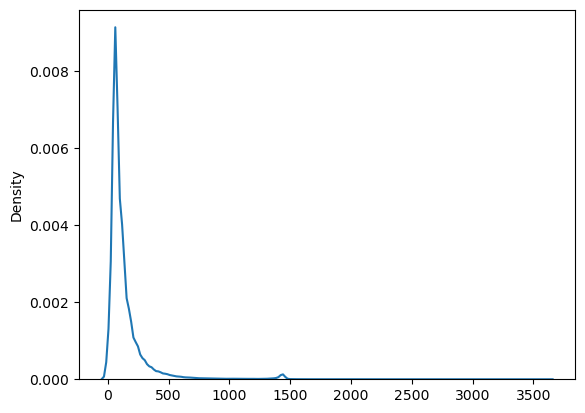

In [21]:
# Calculate the average time of infusion
infusions_minute = ((pd.to_datetime(df_infusions_raw['endtime']) - pd.to_datetime(df_infusions_raw['starttime'])).abs()/np.timedelta64(1, 'm'))
mean_infusions_minute = infusions_minute.mean()
median_infusions_minute = infusions_minute.median(axis=0)
max_infusions_minute = infusions_minute.max()
min_infusions_minute = infusions_minute.min()
print ("Mean Infusions Minutes:             {}".format(mean_infusions_minute))
print ("Median Infutions Minutes:           {}".format(median_infusions_minute))
print ("Max Infutions Minutes:              {}".format(max_infusions_minute))
print ("Min Infutions Minutes:              {}".format(min_infusions_minute))
sns.kdeplot(infusions_minute)
plt.show()

#sns.violinplot(df_infusions_raw["STATUSDESCRIPTION"],infusions_minute,gridsize = 50,)
#plt.show()

## Extraction of boluses of short-acting insulin

In [30]:
# short bolus insulin , Filter short-acting boluses
df_short_bolus_insulin = insulin[(insulin['insulintype']=="Short") &
                               (insulin['insulinadmin'].str.contains('BOLUS'))].copy(deep=True) #短效胰岛素的注射项目

# Display results
display(HTML('<h5>short_bolus_insulin contains the following information</h5>'))
print("Entries:             {}".format(df_short_bolus_insulin.shape[0]))
print("Patients:            {}".format(df_short_bolus_insulin['subject_id'].nunique()))
print("Hospital admissions: {}".format(df_short_bolus_insulin['hadm_id'].nunique()))
print('ICU stays:           {}'.format(df_short_bolus_insulin['stay_id'].nunique()))
display(HTML('<h5>Amount of Short_Bolus_Insulin</h5>'))
print ("Mean:             {}".format(df_short_bolus_insulin["amount"].mean()))
print ("Median:           {}".format(df_short_bolus_insulin["amount"].median(axis=0)))
print ("Max:              {}".format(df_short_bolus_insulin["amount"].max()))
print ("Min:              {}".format(df_short_bolus_insulin["amount"].min()))

display(df_short_bolus_insulin.describe())

Entries:             244000
Patients:            25122
Hospital admissions: 30067
ICU stays:           32445


Mean:             4.64924303278895
Median:           4.0
Max:              1600.0
Min:              0.0


,subject_id,hadm_id,stay_id,amount,rate,itemid,patientweight
count,2.440000e+05,2.440000e+05,2.440000e+05,244000.000000,0.0,244000.000000,244000.000000
mean,1.495725e+07,2.503110e+07,3.500221e+07,4.649243,NaN,223282.900439,87.236530
std,2.880107e+06,2.859010e+06,2.905659e+06,5.842944,NaN,375.531256,34.635347
min,1.000201e+07,2.000009e+07,3.000015e+07,0.000000,NaN,223258.000000,1.000000
25%,1.245156e+07,2.257801e+07,3.246446e+07,2.000000,NaN,223258.000000,70.000000
50%,1.497484e+07,2.507744e+07,3.504262e+07,4.000000,NaN,223258.000000,84.000000
75%,1.740113e+07,2.747673e+07,3.750272e+07,6.000000,NaN,223262.000000,99.700000
max,1.999984e+07,2.999983e+07,3.999955e+07,1600.000000,NaN,229299.000000,11409.000000


In [31]:
# The injected insulin doses under 99.9%
df_short_bolus_insulin['amount'].quantile(.999)

35.0

In [32]:
 # Remove doses <= 0 U
df_short_bolus_insulin = df_short_bolus_insulin[df_short_bolus_insulin['amount'] > 0]
print("Entries after removing values < 0U: {}".format(df_short_bolus_insulin.shape[0]))

# Drop boluses over 99th percentile
P99_bol_s = df_short_bolus_insulin['amount'].quantile(.999)
df_short_bolus_insulin = df_short_bolus_insulin[(df_short_bolus_insulin['amount'] < (df_short_bolus_insulin['amount'].quantile(.999)))]
print("Entries after removing values > 999P: {}".format(df_short_bolus_insulin.shape[0]))

# Display results
display(HTML('<h5>Short-acting boluses 99th percentile</h5>'))
display('P99: {:.2f}'.format(P99_bol_s))

display(HTML('<h5>Amount of Short_Bolus_Insulin after removing</h5>'))
print ("Mean:             {}".format(df_short_bolus_insulin["amount"].mean()))
print ("Median:           {}".format(df_short_bolus_insulin["amount"].median(axis=0)))
print ("Max:              {}".format(df_short_bolus_insulin["amount"].max()))
print ("Min:              {}".format(df_short_bolus_insulin["amount"].min()))

display(HTML('<h5>Short-acting boluses contains the following updated information</h5>'))
print("Entries:             {}".format(df_short_bolus_insulin.shape[0]))
print("Patients:            {}".format(df_short_bolus_insulin['subject_id'].nunique()))
print("Hospital admissions: {}".format(df_short_bolus_insulin['hadm_id'].nunique()))
print('ICU stays:           {}'.format(df_short_bolus_insulin['stay_id'].nunique()))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(df_short_bolus_insulin['itemid'].value_counts())


Entries after removing values < 0U: 234601
Entries after removing values > 999P: 234358


'P99: 36.00'

Mean:             4.761882675225525
Median:           4.0
Max:              35.0
Min:              0.10000000149011612


Entries:             234358
Patients:            24750
Hospital admissions: 29603
ICU stays:           31920


223258    149109
223262     84323
229299       926
Name: itemid, dtype: int64

In [33]:
df_short_bolus_insulin.to_csv("./Data/short_bolus_insulin_allcol.csv", index=False, encoding='utf8', header = True)

#### Drop usesless columns from short_bolus_insulin records

In [34]:
df_short_bolus_insulin_dropcols = df_short_bolus_insulin.drop(["amountuom","rate","rateuom","statusdescription","insulintype"],axis=1)

display(df_short_bolus_insulin_dropcols.head())

,subject_id,hadm_id,stay_id,starttime,endtime,storetime,amount,itemid,patientweight,insulinadmin
0,12466550,23998182,30000153,2174-09-29 20:12:00,2174-09-29 20:13:00,2174-09-29 21:12:00,2.0,223258,70.0,BOLUS_INJECTION
3,13180007,27543152,30000213,2162-06-21 18:41:00,2162-06-21 18:42:00,2162-06-21 18:41:00,2.0,223258,84.7,BOLUS_INJECTION
4,13180007,27543152,30000213,2162-06-21 23:00:00,2162-06-21 23:01:00,2162-06-22 01:59:00,4.0,223258,84.7,BOLUS_INJECTION
6,13180007,27543152,30000213,2162-06-22 12:00:00,2162-06-22 12:01:00,2162-06-22 12:31:00,4.0,223258,84.7,BOLUS_INJECTION
7,13180007,27543152,30000213,2162-06-22 17:00:00,2162-06-22 17:01:00,2162-06-22 17:29:00,10.0,223258,84.7,BOLUS_INJECTION


In [33]:
df_short_bolus_insulin_dropcols.to_csv("./Data/short_bolus_insulin_dropcols.csv", index=False, encoding='utf8', header = True)

In [35]:
# Display counts and descriptive statistics
display(HTML('<h5>All Short-Bolus insulin doses after cleaning</h5>'))
display(df_short_bolus_insulin_dropcols[['amount']].describe())

boluses_cur = df_short_bolus_insulin_dropcols[(df_short_bolus_insulin_dropcols['insulinadmin'].str.contains('BOLUS'))].shape[0]
boluses_intravenous_cur = df_short_bolus_insulin_dropcols[(df_short_bolus_insulin_dropcols['insulinadmin']=='BOLUS_PUSH')].shape[0]
boluses_subcutaneous_cur =df_short_bolus_insulin_dropcols[(df_short_bolus_insulin_dropcols['insulinadmin']=='BOLUS_INJECTION')].shape[0]
infusions_cur = df_short_bolus_insulin_dropcols[(df_short_bolus_insulin_dropcols['insulinadmin'] == 'INFUSION')].shape[0]

# Display results
display(HTML('<h5>Contains the following information</h5>'))
print("Entries:             {}".format(df_short_bolus_insulin_dropcols.shape[0]))
print("Patients:            {}".format(df_short_bolus_insulin_dropcols['subject_id'].nunique()))
print("Hospital admissions: {}".format(df_short_bolus_insulin_dropcols['hadm_id'].nunique()))
print('ICU stays:           {}'.format(df_short_bolus_insulin_dropcols['stay_id'].nunique()))
print('Boluses:              {}'.format(boluses_cur))
print('Boluses subcutaneous: {}'.format(boluses_subcutaneous_cur))
print('Boluses intravenous:  {}'.format(boluses_intravenous_cur))
print('Infusions:            {}'.format(infusions_cur))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(df_short_bolus_insulin_dropcols['itemid'].value_counts())

# Administration route
display(HTML('<h5>Administration routes:</h5>'))
display(df_short_bolus_insulin_dropcols['insulinadmin'].value_counts())

,amount
count,234358.000000
mean,4.761883
std,3.629479
min,0.100000
25%,2.000000
50%,4.000000
75%,6.000000
max,35.000000


Entries:             234358
Patients:            24750
Hospital admissions: 29603
ICU stays:           31920
Boluses:              234358
Boluses subcutaneous: 202900
Boluses intravenous:  31458
Infusions:            0


223258    149109
223262     84323
229299       926
Name: itemid, dtype: int64

BOLUS_INJECTION    202900
BOLUS_PUSH          31458
Name: insulinadmin, dtype: int64

## Extraction of blood glucose test results

The following item id's were identified:

| Item id | Description                 | Source    |
|:-------:|-----------------------------|:---------:|
| 225664  | Glucose finger stick        |CHARTEVENTS|
| 220621  | Glucose (serum)             |CHARTEVENTS|
| 226537  | Glucose (whole blood)       |CHARTEVENTS|
| 50931   | GLUCOSE,CHEMISTRY,BLOOD     |LABEVENTS  |
| 50809   | GLUCOSE,BLOOD GAS,BLOOD   |LABEVENTS  |
| 52569   | GLUCOSE,CHEMISTRY,BLOOD    |LABEVENTS  |
| 52027   | GLUCOSE WHOLE BLOOD,BLOOD GAS  |LABEVENTS  


            


In [12]:
warnings.simplefilter('ignore')
# Change the database settings here
conn = psycopg2.connect(database="mimiciv", user="postgres", password="mypassword", host="127.0.0.1", port="5432")


query="""
WITH chart AS(  -- Import data stored in CHARTEVENTS table
    SELECT ce.subject_id, ce.hadm_id, ce.stay_id, ce.charttime, ce.storetime
    , (CASE
            WHEN itemid IN (220621,226537,225664)
            AND ce.valuenum > 0 THEN valuenum            
            ELSE null END) AS Glu_Chart
    ,ce.valueuom,ce.itemid, 1 AS idi
    FROM mimic_icu.chartevents ce
    WHERE ce.itemid IN(
                        225664, --	Glucose finger stick
                        220621, --	Glucose (serum)血清葡萄糖
                        226537  --	Glucose (whole blood)全血葡萄糖
                        )
)
, labv AS( -- Import data stored in LABEVENTS table
    SELECT le.SUBJECT_ID, le.HADM_ID 
    , CAST(le.CHARTTIME AS TIMESTAMP) AS CHARTTIME
    , CAST(le.STORETIME AS TIMESTAMP) AS STORETIME
    , (CASE
            WHEN itemid IN (50809,50931,52569,52027) AND valuenum > 0
            THEN valuenum ELSE null END) AS Glu_Labv
    ,le.valueuom, itemid, 2 AS idi
    FROM mimic_hosp.labevents le	 
    WHERE le.itemid IN(50931     -- GLUCOSE | CHEMISTRY | BLOOD 
                      ,50809     -- GLUCOSE | BLOOD GAS | BLOOD
                      ,52569     -- GLUCOSE | CHEMISTRY | BLOOD
                      ,52027)    -- GLUCOSE WHOLE BLOOD| BLOOD GAS | BLOOD                    
)
-- Join both tables/sources

SELECT pt.SUBJECT_ID, pt.HADM_ID, pt.STAY_ID
    , CAST(pt.CHARTTIME AS TIMESTAMP) AS CHARTTIME
    , CAST(pt.STORETIME AS TIMESTAMP) AS STORETIME
    , pt.glucose,pt.valueuom
    , COALESCE(pt.CH, pt.LB) AS ITEM_GLC
FROM (
    -- Call the temporary table LABV
    SELECT subject_id, hadm_id, null AS stay_id, charttime
    , storetime, glu_labv AS glucose,valueuom,itemid AS LB, null AS CH 
    FROM labv AS le

    UNION DISTINCT

    -- Call the temporary table CHART                    
    SELECT subject_id, hadm_id, stay_id, charttime, storetime, Glu_Chart,valueuom, null
    , itemid FROM chart as ce
) pt
WHERE pt.glucose IS NOT null
GROUP BY pt.subject_id,pt.hadm_id,pt.STAY_ID,pt.charttime,pt.STORETIME,glucose,valueuom,pt.CH,pt.LB
ORDER BY subject_id,hadm_id,STAY_ID,charttime 
"""

Glucose = pd.read_sql(query,conn)

In [13]:
print("finish")

finish


In [14]:
Glucose.head()

,subject_id,hadm_id,stay_id,charttime,storetime,glucose,valueuom,item_glc
0,10000032,22595853.0,NaN,2180-05-07 05:05:00,2180-05-07 07:03:00,99.0,mg/dL,50931
1,10000032,22841357.0,NaN,2180-06-27 05:10:00,2180-06-27 07:26:00,71.0,mg/dL,50931
2,10000032,25742920.0,NaN,2180-08-06 06:36:00,2180-08-06 07:38:00,95.0,mg/dL,50931
3,10000032,25742920.0,NaN,2180-08-07 00:59:00,2180-08-07 02:04:00,102.0,mg/dL,50931
4,10000032,25742920.0,NaN,2180-08-07 06:15:00,2180-08-07 08:35:00,87.0,mg/dL,50931


In [15]:
# Coerse columns
Glucose[["charttime","storetime"]] = Glucose[
    ["charttime","storetime"]].apply(pd.to_datetime, format='%Y%m%d %H:%M:%S')

display(Glucose.tail())

,subject_id,hadm_id,stay_id,charttime,storetime,glucose,valueuom,item_glc
4450928,19999987,23865745.0,NaN,2145-11-05 06:10:00,2145-11-05 07:02:00,90.0,mg/dL,50931
4450929,19999987,23865745.0,NaN,2145-11-06 10:07:00,2145-11-06 11:19:00,124.0,mg/dL,50931
4450930,19999987,23865745.0,NaN,2145-11-07 06:00:00,2145-11-07 06:57:00,94.0,mg/dL,50931
4450931,19999987,23865745.0,NaN,2145-11-09 05:30:00,2145-11-09 06:59:00,99.0,mg/dL,50931
4450932,19999987,NaN,NaN,2145-11-02 19:49:00,2145-11-02 19:54:00,134.0,mg/dL,50809


In [16]:

# Display information
display(HTML('<h5>Description of all glucose readings</h5>'))
display(Glucose[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Entries:             {}".format(Glucose.shape[0]))
print("Patients:            {}".format(Glucose['subject_id'].nunique()))
print("Hospital admissions: {}".format(Glucose['hadm_id'].nunique()))
print('ICU stays:           {}'.format(Glucose['stay_id'].nunique()))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(Glucose['item_glc'].value_counts())

# Item id's
display(HTML('<h5>The gathered VALUEUOMs are:</h5>'))
display(Glucose['valueuom'].value_counts())

,glucose
count,4.450933e+06
mean,1.531087e+02
std,4.350753e+03
min,1.200000e-01
25%,9.700000e+01
50%,1.180000e+02
75%,1.520000e+02
max,1.276103e+06


Entries:             4450933
Patients:            249379
Hospital admissions: 334797
ICU stays:           74677


50931     2829285
225664     802802
220621     442445
50809      219081
226537     156947
52569         373
Name: item_glc, dtype: int64

mg/dL    3625093
Name: valueuom, dtype: int64

#### Item id's distributions


In [42]:
# Initialize the FacetGrid object
sns.set(style="darkgrid", rc=None)

# Plot
pal = sns.cubehelix_palette((Glucose['item_glc'].nunique()), rot=-.4, light=.7)
g = sns.FacetGrid(Glucose[Glucose.glucose < 9000]
    , row="item_glc", hue="item_glc", aspect = 5, palette=pal, row_order=[50931,225664,220621,50809,226537 ,52569 ] , height = 4)
g.map(sns.stripplot, "glucose", clip_on=False, alpha=0.8, jitter=True)
g.map(plt.axvline, x=500, ymin=0, ymax=1, clip_on=False, color = 'm')
g.map(plt.axvline, x=1000, ymin=0, ymax=1, clip_on=False, color = 'r')
plt.xlabel('Glucose (mg/dL)', fontsize=18)
plt.xlim(-20,(max(Glucose.glucose[Glucose.glucose < 9000])+10))
ax = plt.gca()
ax.legend(['500 mg/dL','1000 mg/dL','data'],fontsize=16)
ax.tick_params(labelsize = 16)

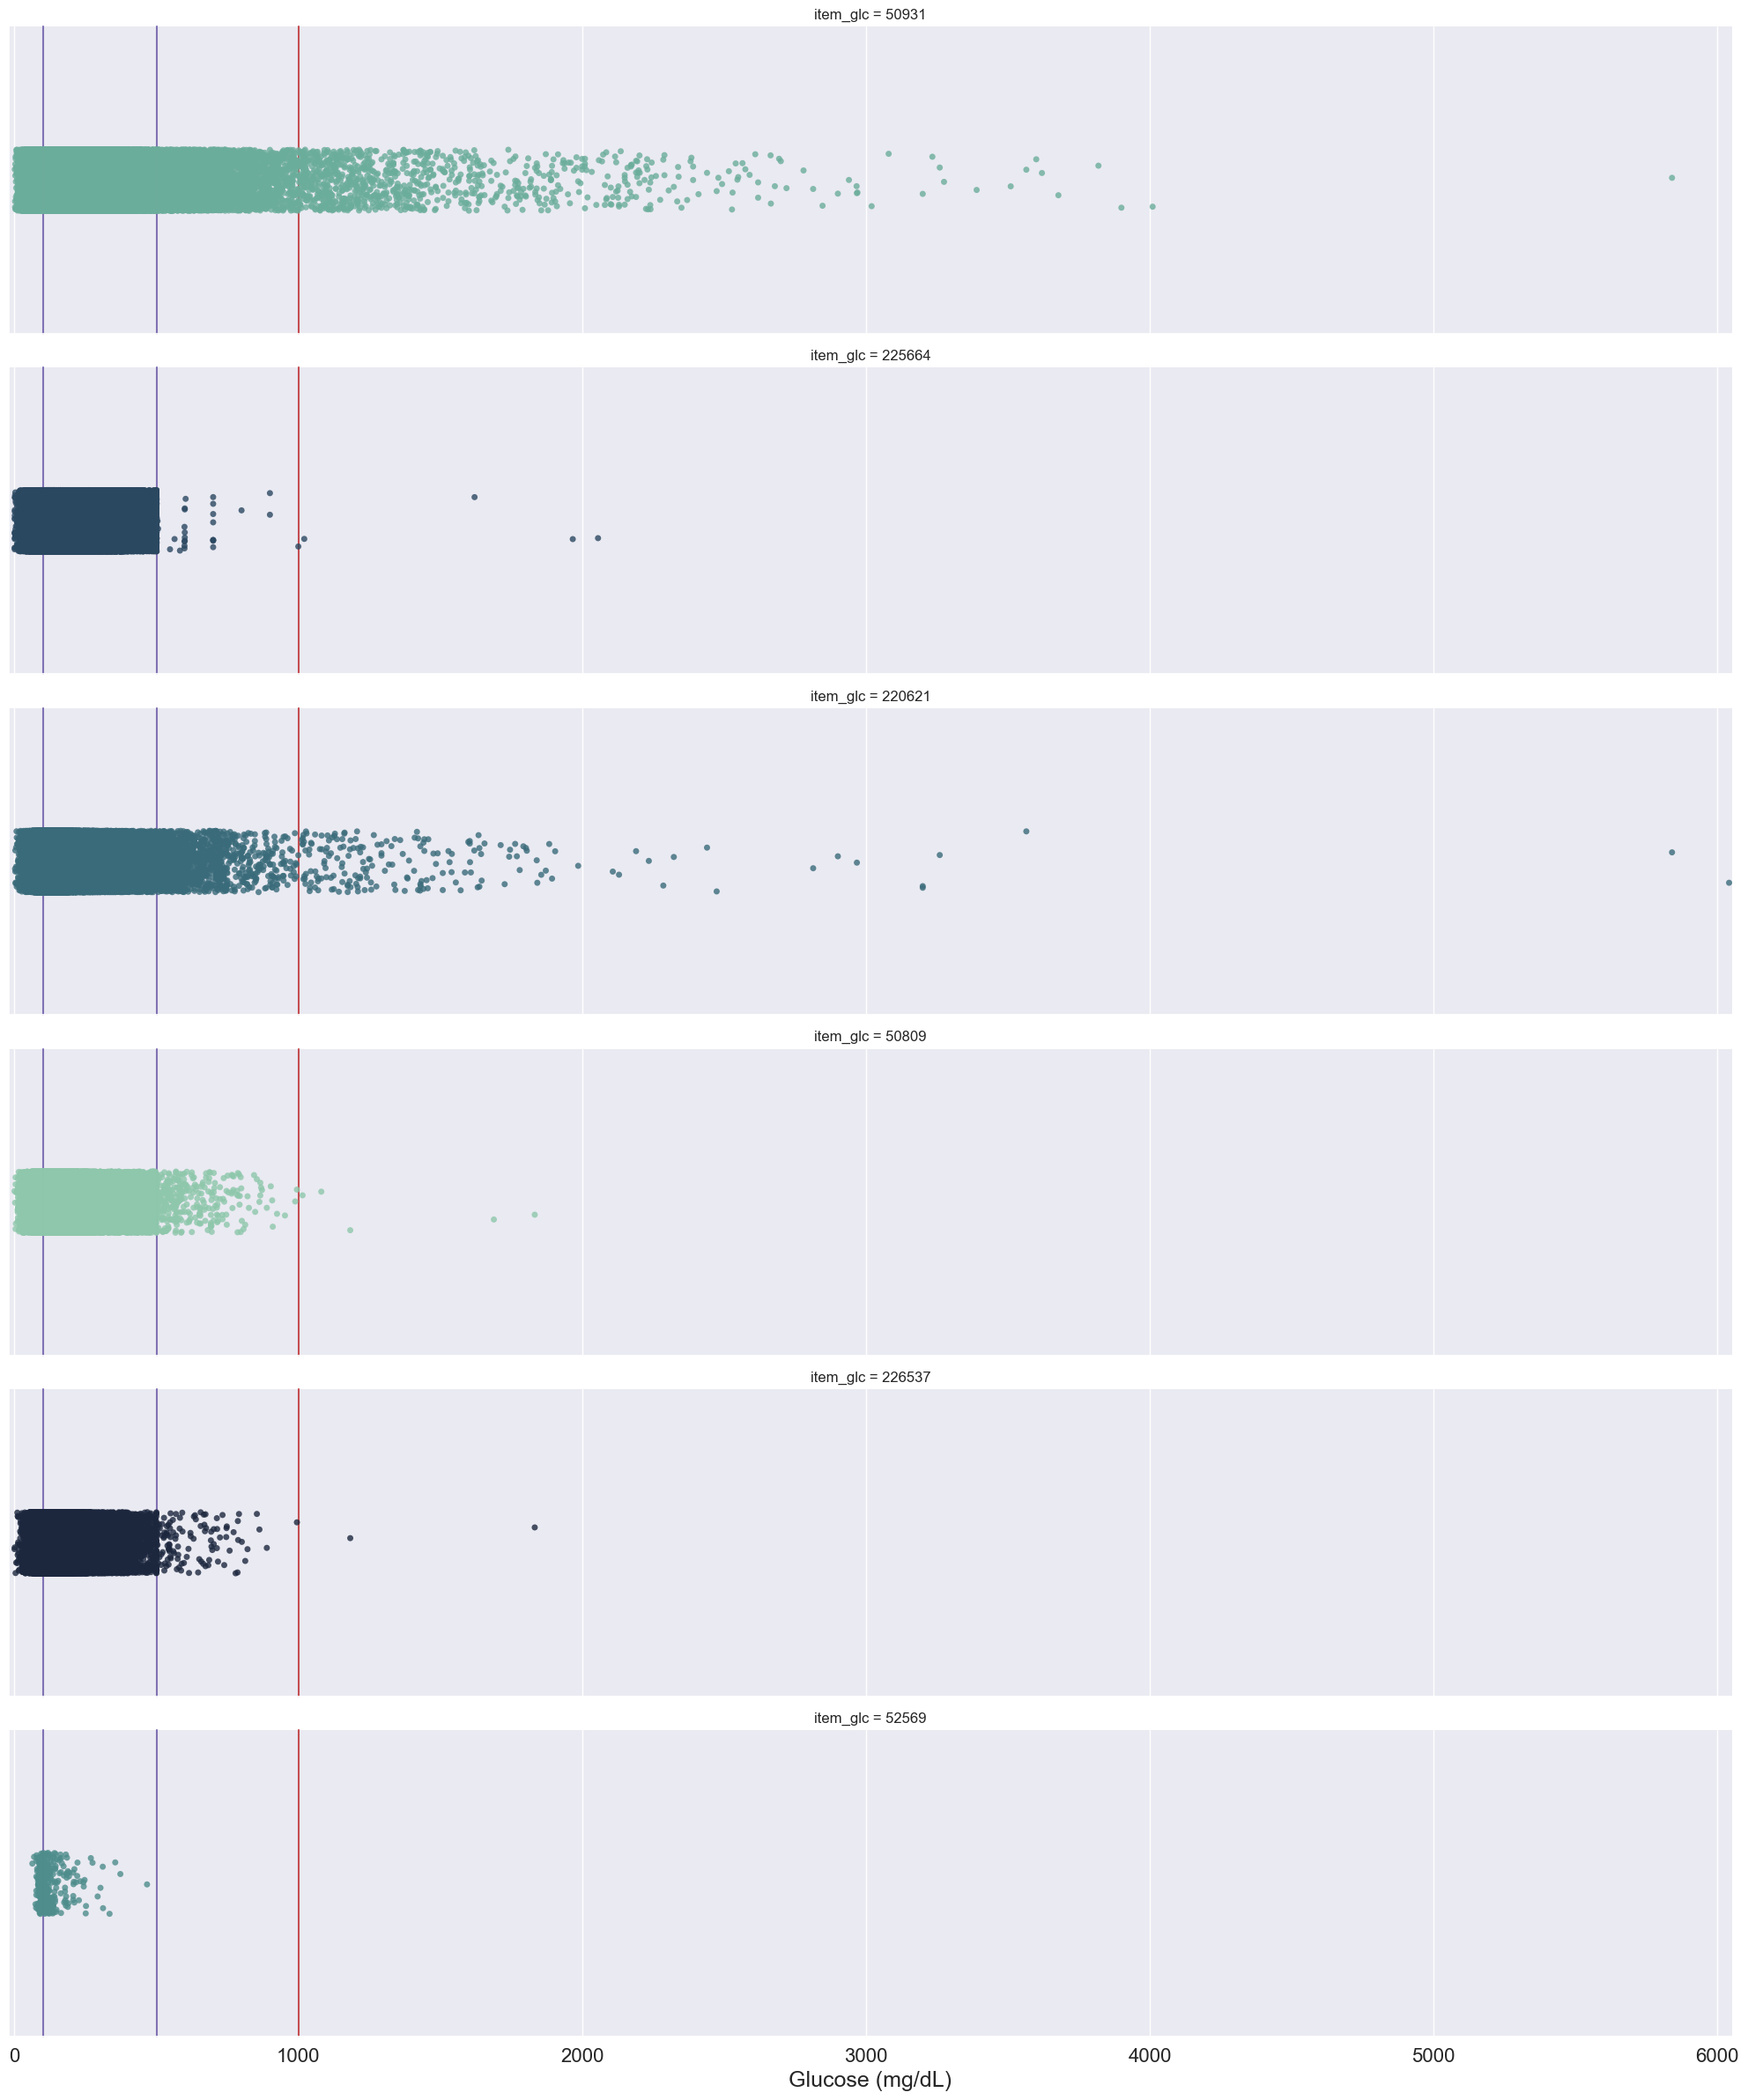

In [43]:
g.map(plt.axvline, x=100, ymin=0, ymax=1, clip_on=False, color = 'm')
plt.show()

In [36]:
# We only need the glucose records from patients that have insulin injection info

insulin_patients = list(df_short_bolus_insulin_dropcols.hadm_id.dropna().unique())

Glucose_tmp = Glucose[Glucose['hadm_id'].isin(insulin_patients)].copy()

# Save as CSV file, uncomment and modify as needed.
Glucose_tmp.to_csv("./Data/GlucoseALL.csv", index=False, encoding='utf8', header = True)

In [37]:
Glucose_tmp.shape

(1694532, 8)

In [39]:
# Display statistics
display(HTML('<h4>Statistics of all glucose readings within insulin input</h4>'))
display(Glucose_tmp[['glucose']].describe())

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
countGLCraw = Glucose_tmp.groupby('hadm_id').count().glucose.copy()
display(HTML('<h5>Readings per hospital stay</h5>'))
print("Readings (raw) per hospital stay: {:0.2f} +/- {:0.2f}".format(countGLCraw.mean(), countGLCraw.std()))

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_both_raw = Glucose_tmp.copy(deep=True)
df_both_raw['diff'] = df_both_raw.sort_values(['hadm_id', 'charttime']).groupby('hadm_id')['charttime'].diff().copy()
df_both_raw['diff_hr']= df_both_raw['diff'].dt.seconds/3600
display(HTML('<h5>Time lapse between readings</h5>'))
print("Time lapse (hr) between raw readings/HADM stay: {:0.2f} +/- {:0.2f}".format(
    df_both_raw['diff_hr'].mean(),df_both_raw['diff_hr'].std()))

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
display(HTML('<h5>Contains the following information</h5>'))
print("Entries:             {}".format(Glucose_tmp.shape[0]))
print("Patients:            {}".format(Glucose_tmp['subject_id'].nunique()))
print("Hospital admissions: {}".format(Glucose_tmp['hadm_id'].nunique()))
print('ICU stays:           {}'.format(Glucose_tmp['stay_id'].nunique()))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(Glucose_tmp['item_glc'].value_counts())



,glucose
count,1.694532e+06
mean,1.796141e+02
std,5.152872e+03
min,1.200000e-01
25%,1.130000e+02
50%,1.380000e+02
75%,1.760000e+02
max,9.999990e+05


Readings (raw) per hospital stay: 57.24 +/- 70.94


Time lapse (hr) between raw readings/HADM stay: 3.50 +/- 5.00


Entries:             1694532
Patients:            24755
Hospital admissions: 29603
ICU stays:           34039


225664    669198
50931     463522
220621    276121
226537    142847
50809     142844
Name: item_glc, dtype: int64

In [61]:
# Remove duplicated: same subject id, hadm id, and charttime
Glucose_tmp2 = Glucose_tmp.drop_duplicates(["subject_id","hadm_id","charttime","glucose"], keep= 'last').copy(deep=True)
Glucose_tmp2['glcsource'] = np.nan

# Display information
display(HTML('<h5>Description of all glucose readings</h5>'))
display(Glucose_tmp2[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Entries:             {}".format(Glucose_tmp2.shape[0]))
print("Patients:            {}".format(Glucose_tmp2['subject_id'].nunique()))
print("Hospital admissions: {}".format(Glucose_tmp2['hadm_id'].nunique()))
print('ICU stays:           {}'.format(Glucose_tmp2['stay_id'].nunique()))

display(HTML('<h5>The number of raws has been droped:</h5>'))
print(Glucose_tmp.shape[0]-Glucose_tmp2.shape[0])

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(Glucose_tmp2['item_glc'].value_counts())



,glucose
count,1.299691e+06
mean,1.884025e+02
std,5.883611e+03
min,1.200000e-01
25%,1.130000e+02
50%,1.380000e+02
75%,1.770000e+02
max,9.999990e+05


Entries:             1299691
Patients:            24755
Hospital admissions: 29603
ICU stays:           33243


394841


225664    668981
50931     463511
50809     142829
226537     17733
220621      6637
Name: item_glc, dtype: int64

#### Fingerstick Samples

In [62]:
# Filter fingerstick
Glucose_step3_finger = Glucose_tmp2[(Glucose['item_glc'] == 225664)|(Glucose['item_glc'] == 226537) ]

# Display statistics (updated)
display(HTML('<h5>Statistics of fingerstick glucose readings</h5>'))
display(Glucose_step3_finger[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Entries:             {}".format(Glucose_step3_finger.shape[0]))
print("Patients:            {}".format(Glucose_step3_finger['subject_id'].nunique()))
print("Hospital admissions: {}".format(Glucose_step3_finger['hadm_id'].nunique()))
print('ICU stays:           {}'.format(Glucose_step3_finger['stay_id'].nunique()))

,glucose
count,686714.000000
mean,189.321464
std,5529.469920
min,1.000000
25%,116.000000
50%,144.000000
75%,185.000000
max,999999.000000


Entries:             686714
Patients:            24616
Hospital admissions: 29442
ICU stays:           33195


In [63]:
warnings.simplefilter('ignore')

# Remove values over 499 and below 10 in fingersitck results
Glucose_step3_finger_sat = Glucose_step3_finger[(Glucose_step3_finger['glucose'] < 500)]
Glucose_step3_finger_sat = Glucose_step3_finger_sat[(Glucose_step3_finger_sat['glucose'] >= 10)]
# Add flag column
Glucose_step3_finger_sat['glcsource'] = "fingerstick"

# Display statistics (updated)
display(HTML('<h5>Statistics of fingerstick glucose readings</h5>'))
display(Glucose_step3_finger_sat[['glucose']].describe())

display(HTML('<h5>fingerstick without >500 and <10:</h5>'))
print("Entries:             {}".format(Glucose_step3_finger_sat.shape[0]))
print("Patients:            {}".format(Glucose_step3_finger_sat['subject_id'].nunique()))
print("Hospital admissions: {}".format(Glucose_step3_finger_sat['hadm_id'].nunique()))
print('ICU stays:           {}'.format(Glucose_step3_finger_sat['stay_id'].nunique()))

,glucose
count,686056.000000
mean,158.356889
std,62.444137
min,10.000000
25%,116.000000
50%,144.000000
75%,184.000000
max,499.000000


Entries:             686056
Patients:            24616
Hospital admissions: 29442
ICU stays:           33194


#### Laboratory samples

In [64]:
# Filter
Glucose_step3_blood = Glucose_tmp2[((Glucose_tmp2['item_glc'] == 220621)|
         (Glucose_tmp2['item_glc'] == 50931) | 
        (Glucose_tmp2['item_glc'] == 50809)
        )]

# Display information
display(HTML('<h5>Description for lab samples</h5>'))
display(Glucose_step3_blood[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Entries:             {}".format(Glucose_step3_blood.shape[0]))
print("Patients:            {}".format(Glucose_step3_blood['subject_id'].nunique()))
print("Hospital admissions: {}".format(Glucose_step3_blood['hadm_id'].nunique()))
print('ICU stays:           {}'.format(Glucose_step3_blood['stay_id'].nunique()))

,glucose
count,612977.000000
mean,187.372889
std,6256.595264
min,0.120000
25%,109.000000
50%,133.000000
75%,169.000000
max,999999.000000


Entries:             612977
Patients:            24741
Hospital admissions: 29578
ICU stays:           2446


In [65]:
Glucose_step3_blood_sat = Glucose_step3_blood[(Glucose_step3_blood['glucose'] > 900)]
#Glucose_step3_blood_sat[(Glucose_step3_blood['SUBJECT_ID']==10027445)]
Glucose_step3_blood_sat

,subject_id,hadm_id,stay_id,charttime,storetime,glucose,valueuom,item_glc,glcsource
9313,10020740,23831430.0,NaN,2150-03-15 02:15:00,2150-03-15 03:20:00,909.0,mg/dL,50931,NaN
14219,10032381,20176432.0,NaN,2115-07-14 01:46:00,2115-07-14 03:22:00,1059.0,mg/dL,50931,NaN
30843,10074556,20846673.0,NaN,2126-02-09 04:46:00,2126-02-09 08:00:00,2172.0,mg/dL,50931,NaN
38585,10098215,20652197.0,NaN,2118-09-10 05:59:00,2118-09-10 08:33:00,1252.0,mg/dL,50931,NaN
57453,10138124,24246710.0,NaN,2114-05-29 07:30:00,2114-05-29 08:44:00,1387.0,mg/dL,50931,NaN
...,...,...,...,...,...,...,...,...,...
4355318,19791060,27984084.0,36212649.0,2148-10-25 01:00:00,2148-10-25 01:44:00,910.0,mg/dL,220621,NaN
4355348,19791060,27984084.0,NaN,2148-10-24 23:25:00,2148-10-25 00:27:00,1222.0,mg/dL,50931,NaN
4357558,19796205,29475977.0,NaN,2145-08-06 07:50:00,2145-08-06 09:17:00,1208.0,mg/dL,50931,NaN
4363238,19808487,29124262.0,NaN,2162-02-24 15:29:00,2162-02-24 16:46:00,1408.0,mg/dL,50931,NaN


In [66]:
# Remove values over 1000
Glucose_step3_blood_sat = Glucose_step3_blood[(Glucose_step3_blood['glucose'] < 1000)]
Glucose_step3_blood_sat = Glucose_step3_blood_sat[(Glucose_step3_blood_sat['glucose'] >= 10)]
# Add flag column
Glucose_step3_blood_sat['glcsource'] = "BLOOD"

# Display statistics (updated)
display(HTML('<h5>Statistics for lab samples</h5>'))
display(Glucose_step3_blood_sat[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Entries:             {}".format(Glucose_step3_blood_sat.shape[0]))
print("Patients:            {}".format(Glucose_step3_blood_sat['subject_id'].nunique()))
print("Hospital admissions: {}".format(Glucose_step3_blood_sat['hadm_id'].nunique()))
print('ICU stays:           {}'.format(Glucose_step3_blood_sat['stay_id'].nunique()))

,glucose
count,612623.000000
mean,147.545887
std,62.516731
min,11.000000
25%,109.000000
50%,133.000000
75%,169.000000
max,999.000000


Entries:             612623
Patients:            24741
Hospital admissions: 29578
ICU stays:           2419


#### Merging Filtered Laboratory samples and  Fingerstick Samples

In [67]:
warnings.simplefilter('default')
print("finger Entries:             {}".format(Glucose_step3_finger_sat.shape[0]))
print("blood Entries:              {}".format(Glucose_step3_blood_sat.shape[0]))

Glucose_step3 = pd.concat([Glucose_step3_finger_sat, Glucose_step3_blood_sat]
, keys=['subject_id', 'hadm_id'], verify_integrity=True
, ignore_index=True)

# Display statistics (updated)
display(HTML('<h5>Statistics for all glucose readings</h5>'))
display(Glucose_step3[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Entries:             {}".format(Glucose_step3.shape[0]))
print("Patients:            {}".format(Glucose_step3['subject_id'].nunique()))
print("Hospital admissions: {}".format(Glucose_step3['hadm_id'].nunique()))
print('ICU stays:           {}'.format(Glucose_step3['stay_id'].nunique()))

finger Entries:             686056
blood Entries:              612623


,glucose
count,1.298679e+06
mean,1.532570e+02
std,6.271102e+01
min,1.000000e+01
25%,1.120000e+02
50%,1.380000e+02
75%,1.770000e+02
max,9.990000e+02


Entries:             1298679
Patients:            24755
Hospital admissions: 29603
ICU stays:           33240


#### Differences between fingerstick and lab analyzer

In [68]:

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
countGLCfinger = Glucose_step3_finger_sat.groupby('hadm_id').count().glucose.copy()

countGLClab = Glucose_step3_blood_sat.groupby('hadm_id').count().glucose.copy()

countGLC = Glucose_step3.groupby('hadm_id').count().glucose.copy()

display(HTML('<h2>Readings per hospital stay</h2>'))
print("Readings (fingerstick) per hospital stay: {:0.2f} +/- {:0.2f}".format(countGLCfinger.mean(),
                                                                       countGLCfinger.std()))
print("Readings (lab analyzer) per hospital stay: {:0.2f} +/- {:0.2f}".format(countGLClab.mean(),
                                                                       countGLClab.std()))
print("Readings (both methods) per hospital stay: {:0.2f} +/- {:0.2f}".format(countGLC.mean(),
                                                                       countGLC.std()))
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_finger = Glucose_step3_finger_sat.copy(deep=True)
df_finger['diff'] = Glucose_step3_finger_sat.sort_values(['hadm_id','charttime']
                                                        ).groupby('hadm_id')['charttime'].diff().copy()
df_finger['diff_hr']= df_finger['diff'].dt.seconds/3600

df_lab = Glucose_step3_blood_sat.copy(deep=True)
df_lab['diff'] = Glucose_step3_blood_sat.sort_values(['hadm_id','charttime']
                                                    ).groupby('hadm_id')['charttime'].diff().copy()
df_lab['diff_hr']= df_lab['diff'].dt.seconds/3600

df_both = Glucose_step3.copy(deep=True)
df_both['diff'] = Glucose_step3.sort_values(['hadm_id','charttime']
                                           ).groupby('hadm_id')['charttime'].diff().copy()
df_both['diff_hr']= df_both['diff'].dt.seconds/3600

display(HTML('<h2>Time lapse between readings<h2>'))
print("Time lapse (hr) between bedside fingerstick readings/HADM stay: {:0.2f} +/- {:0.2f}".format(df_finger['diff_hr'].mean(),
                                                                                    df_finger['diff_hr'].std()))
print("Time lapse (hr) between lab analyzer readings/HADM stay: {:0.2f} +/- {:0.2f}".format(df_lab['diff_hr'].mean(),
                                                                             df_lab['diff_hr'].std()))
print("Time lapse (hr) between both readings/HADM stay: {:0.2f} +/- {:0.2f}".format(df_both['diff_hr'].mean(),
                                                                             df_both['diff_hr'].std()))

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Readings (fingerstick) per hospital stay: 23.30 +/- 34.12
Readings (lab analyzer) per hospital stay: 20.71 +/- 23.82
Readings (both methods) per hospital stay: 43.87 +/- 52.85


Time lapse (hr) between bedside fingerstick readings/HADM stay: 4.59 +/- 3.98
Time lapse (hr) between lab analyzer readings/HADM stay: 8.16 +/- 7.60
Time lapse (hr) between both readings/HADM stay: 4.59 +/- 5.27


In [71]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Plot TIMEDELTA
plt.figure(figsize=(6,5))
plt.title('Time lapse between glucose reading methods n='+str(df_both.shape[0]),fontsize=18)
sns.kdeplot(df_finger['diff_hr'].dropna(), shade=False, label="Fingerstick")
sns.kdeplot(df_lab['diff_hr'].dropna(), shade=False, label="Lab Analyzer")
sns.kdeplot(df_both['diff_hr'].dropna(), shade=True, label="Combined")
plt.xlabel('\u0394 time (hours)', fontsize=18)
fig = plt.gcf()


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Plot Glucose readings
plt.figure(figsize=(6,5))
plt.title('Density for both glucose reading methods n='+str(Glucose_step3_finger_sat.shape[0]+
                                                           Glucose_step3_blood_sat.shape[0])
        ,fontsize=18)
sns.kdeplot(Glucose_step3_finger_sat.glucose, shade=False, label="Fingerstick")
sns.kdeplot(Glucose_step3_blood_sat.glucose, shade=False, label="Lab Analyzer")
sns.kdeplot(Glucose_step3.glucose, shade=True, label="Combined")
plt.xlabel('Glucose (mg/dL)', fontsize=18)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# Save to CSV. Uncomment as required. DO NOT forget to specify your folder path
Glucose_step3_finger_sat.to_csv("./Data/GlucoseFinger.csv", 
                               index=False, encoding='utf8')
Glucose_step3_blood_sat.to_csv("./Data/GlucoseBlood.csv", 
                               index=False, encoding='utf8')

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


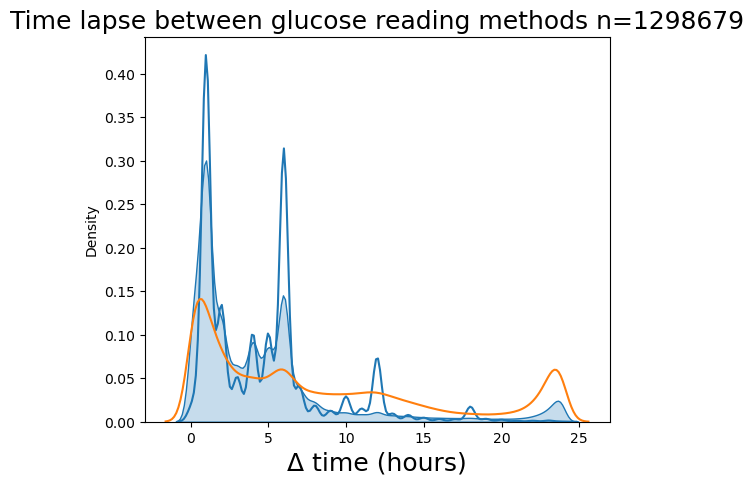

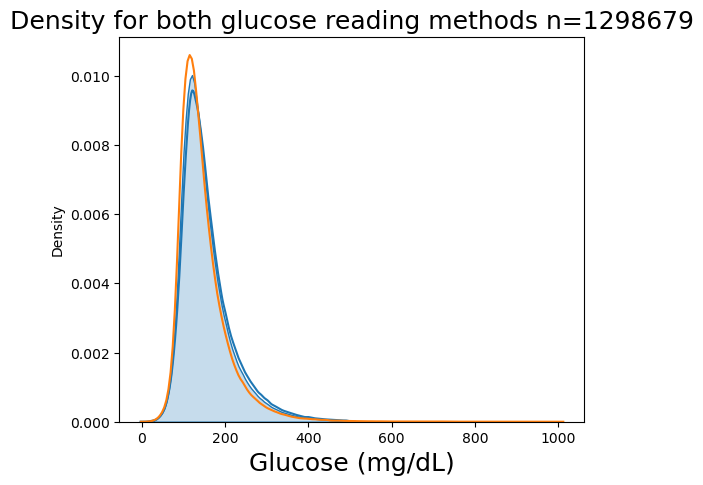

In [72]:
plt.show()

#### CHARTTIME and STORETIME disadjustment

In [75]:
warnings.simplefilter('ignore')
#Glucose_step3.to_csv("./Data/GlucoseBeforeTimeAdjust.csv", index=False, encoding='utf8')

# Find: (CASE WHEN pt.charttime < pt.storetime THEN pt.charttime ELSE pt.storetime END) AS timer_
Glucose_final = Glucose_step3.copy()
Glucose_final['chart_store'] = Glucose_final['charttime'] > Glucose_final['storetime']
# charttime after storetime
# Create subset for plotting
step4_switch_cases = Glucose_final[(Glucose_final.chart_store == True)].copy()
step4_switch_cases['timedelta'] = abs(step4_switch_cases.charttime
                  - step4_switch_cases.storetime).dt.seconds

display(step4_switch_cases.head())

# Replace
Glucose_final.loc[(Glucose_final['chart_store'] == True),
                  'charttime'] = Glucose_final['storetime']

# Display statistics
display(HTML('<h5>Statistics for all glucose readings that got switched their time stamps</h5>'))
display(step4_switch_cases[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Entries:             {}".format(step4_switch_cases.shape[0]))
print("Patients:            {}".format(step4_switch_cases['subject_id'].nunique()))
print("Hospital admissions: {}".format(step4_switch_cases['hadm_id'].nunique()))
print('ICU stays:           {}'.format(step4_switch_cases['stay_id'].nunique()))

,subject_id,hadm_id,stay_id,charttime,storetime,glucose,valueuom,item_glc,glcsource,chart_store,timedelta
1,10002013,23581541.0,39060235.0,2160-05-18 19:00:00,2160-05-18 18:51:00,179.0,None,225664,fingerstick,True,540
7,10002013,23581541.0,39060235.0,2160-05-19 06:30:00,2160-05-19 06:24:00,106.0,None,225664,fingerstick,True,360
11,10002013,23581541.0,39060235.0,2160-05-19 17:00:00,2160-05-19 16:53:00,208.0,None,225664,fingerstick,True,420
15,10002348,22725460.0,32610785.0,2112-12-01 22:00:00,2112-12-01 21:52:00,108.0,None,225664,fingerstick,True,480
16,10002348,22725460.0,32610785.0,2112-12-02 08:00:00,2112-12-02 07:59:00,120.0,None,225664,fingerstick,True,60


,glucose
count,139948.000000
mean,159.925065
std,61.167681
min,12.000000
25%,118.000000
50%,145.000000
75%,186.000000
max,499.000000


Entries:             139948
Patients:            21080
Hospital admissions: 24746
ICU stays:           27085


In [76]:
# Scatter plot timedelta in minutes
df = step4_switch_cases.loc[step4_switch_cases['chart_store']==True].copy()
df['timedelta'] = df['timedelta']/60
display(df[['timedelta']].describe())
df['timedelta'].quantile(0.99)

,timedelta
count,139948.000000
mean,10.661138
std,29.353191
min,0.000000
25%,3.000000
50%,7.000000
75%,14.000000
max,1439.000000


48.0

In [77]:
fig = plt.figure(figsize=(12,10))
sns.scatterplot(x="timedelta",y="glucose",data=df,alpha=0.3)
plt.title('Time difference (CHARTTIME - STORETIME) n='+str(df.shape[0])
        ,fontsize=18)
plt.vlines(df['timedelta'].quantile(0.50), 0, max(df.glucose)
    , color = 'red', linestyles='--',label='Median (7 min)')
plt.vlines(df['timedelta'].quantile(0.95), 0, max(df.glucose)
    , color = '#34A853', linestyles='--',label='$P$ = 95$^{TH}$ (29 min)')
plt.vlines(df['timedelta'].quantile(0.99), 0, max(df.glucose)
    , color = '#9CBF38', linestyles='--',label='$P$ = 99$^{TH}$ (48 min)')
plt.vlines(90, 0, max(df.glucose), color = '#E7BE2D', linestyles='dotted'
           ,label='90 min')
plt.xlabel('$\Delta$ time (min)', fontsize=18)
plt.ylabel('Glucose (mg/dL)', fontsize=18)
plt.ylim(0,(max(df.glucose)))
plt.xlim(0,(max(df.timedelta)+100))
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
ax.legend(fontsize=18)

# Save figure; uncomment and modify as needed.
#fig.savefig(base_dir+'/DataExtraction/MIMIC_III/Figures/SwitchCHART_STORE.png', 
#            bbox_inches='tight', dpi=fig.dpi)

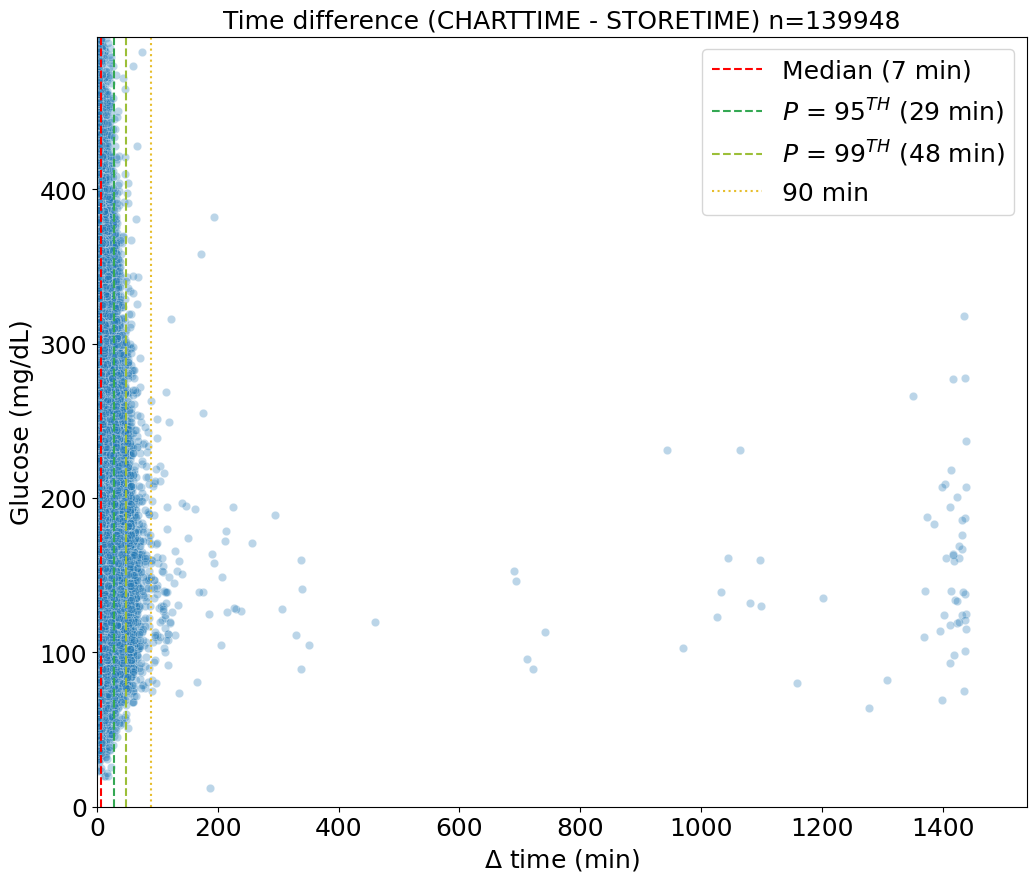

In [78]:
plt.show()

In [204]:
# Display statistics for Glucose curated
display(HTML('<h5>Statistics for all curated glucose readings</h5>'))
display(Glucose_final[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Entries:             {}".format(Glucose_final.shape[0]))
print("Patients:            {}".format(Glucose_final['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose_final['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(Glucose_final['STAY_ID'].nunique()))
print("Readings per patient: {:0.2f} +/- {:0.2f}".format(countGLC.mean(),
                                                         countGLC.std()))

# Item id's
print("")
display(HTML('<h5>The gathered item ids are:</h5>'))
display(Glucose_final['ITEM_GLC'].value_counts())

,glucose
count,1.298679e+06
mean,1.532570e+02
std,6.271102e+01
min,1.000000e+01
25%,1.120000e+02
50%,1.380000e+02
75%,1.770000e+02
max,9.990000e+02


Entries:             1298679
Patients:            24755
Hospital admissions: 29603
ICU stays:           33240
Readings per patient: 43.87 +/- 52.85



225664    668411
50931     463197
50809     142823
226537     17645
220621      6603
Name: ITEM_GLC, dtype: int64

## Final item_glc analysis

In [82]:
warnings.simplefilter('ignore')

# Plot
plt.figure(figsize=(12,20))
pal = sns.cubehelix_palette((Glucose_step3['item_glc'].nunique()), rot=-.4, light=.7)
g = sns.FacetGrid(Glucose_step3[Glucose_step3.glucose < 9000]
    , row="item_glc", hue="item_glc", aspect = 5, palette=pal, row_order=[225664,50931,50809,226537
                                                                          ,220621]
                 , height = 2)
g.map(sns.stripplot, "glucose", clip_on=False, alpha=0.8, jitter=True)
g.map(plt.axvline, x=500, ymin=0, ymax=1, clip_on=False, color = 'm')
g.map(plt.axvline, x=1000, ymin=0, ymax=1, clip_on=False, color = 'r')
plt.xlabel('Glucose (mg/dL)', fontsize=18)
plt.xlim(-20,(max(Glucose_step3.glucose[Glucose_step3.glucose < 9000])+10))
ax = plt.gca()
ax.legend(['500 mg/dL','1000 mg/dL','data'],fontsize=16)
ax.tick_params(labelsize = 16)
fig = plt.gcf()


<Figure size 1200x2000 with 0 Axes>

<Figure size 1200x2000 with 0 Axes>

<Figure size 1200x2000 with 0 Axes>

<Figure size 1200x2000 with 0 Axes>

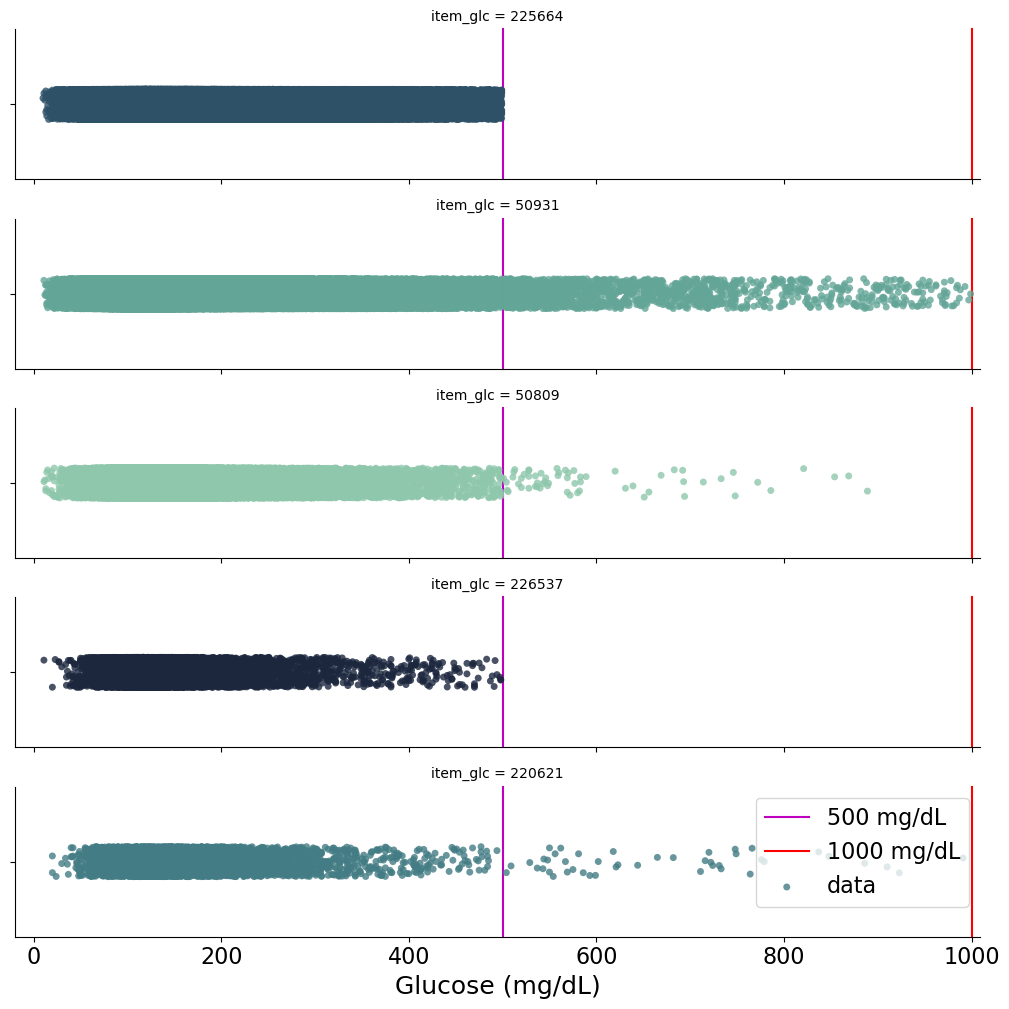

In [83]:
plt.show()
Glucose_final.to_csv("./Data/GlucoseFinal.csv", index=False, encoding='utf8')

## Merging glucose data and insulin data

In [2]:
Glucose_final=pd.read_csv('./Data/GlucoseFinal.csv') 

In [3]:
Glucose_final.head()

,subject_id,hadm_id,stay_id,charttime,storetime,glucose,valueuom,item_glc,glcsource,chart_store
0,10002013,23581541.0,39060235.0,2160-05-18 17:00:00,2160-05-18 17:06:00,154.0,NaN,225664,fingerstick,False
1,10002013,23581541.0,39060235.0,2160-05-18 18:51:00,2160-05-18 18:51:00,179.0,NaN,225664,fingerstick,True
2,10002013,23581541.0,39060235.0,2160-05-18 23:00:00,2160-05-18 23:08:00,126.0,NaN,225664,fingerstick,False
3,10002013,23581541.0,39060235.0,2160-05-19 00:00:00,2160-05-19 00:11:00,130.0,NaN,225664,fingerstick,False
4,10002013,23581541.0,39060235.0,2160-05-19 01:00:00,2160-05-19 01:09:00,119.0,NaN,225664,fingerstick,False


In [13]:
df_short_bolus_insulin_dropcols=pd.read_csv('./Data/short_bolus_insulin_dropcols.csv') 

In [14]:
df_short_bolus_insulin_dropcols.shape

(234358, 10)

In [19]:
warnings.simplefilter('ignore')

# Glucose readings (14 columns)
Glucose_cur = Glucose_final[['subject_id','hadm_id','stay_id','charttime',
                              'glucose','item_glc','glcsource','chart_store']].copy(deep=True)
Glucose_cur['starttime'] = pd.NaT
Glucose_cur['endtime'] = pd.NaT
Glucose_cur['inputamount'] = np.nan
Glucose_cur['input_itemid'] = np.nan
Glucose_cur['patientweight'] = np.nan
Glucose_cur['event'] = np.nan #InsulinAdmin


Glucose_cur.columns = ['subject_id', 'hadm_id', 'stay_id', 'glctimer'
                         , 'glc','item_glc', 'glcsource','chart_store', 'starttime'
                         , 'endtime', 'inputamount', 'input_itemid', 'patientweight'
                         , 'event']

# Insulin events

Insulin_cur =df_short_bolus_insulin_dropcols[['subject_id', 'hadm_id', 'stay_id'
                               , 'starttime', 'endtime', 'amount', 'itemid'
                               , 'patientweight', 'insulinadmin']].copy(deep=True)
Insulin_cur['glctimer'] = pd.NaT
Insulin_cur['glc'] = np.nan
Insulin_cur['item_glc'] = np.nan
Insulin_cur['glcsource'] = np.nan
Insulin_cur['chart_store'] = np.nan

Insulin_cur.columns = ['subject_id', 'hadm_id', 'stay_id', 'starttime'
                         , 'endtime', 'inputamount', 'input_itemid', 'patientweight'
                         , 'event', 'glctimer'
                         , 'glc','item_glc', 'glcsource','chart_store']

# Save as CSV file, uncomment and modify as needed.
#Insulin_cur.to_csv("./DataExtraction/InsulinInputsCurated.csv", 
#                  index=False, encoding='utf8')

In [20]:
# Function to coerse columns with corrupted datetime data.
def convert_to_datetime(df,time_cols):
    for t_col in time_cols:
        df[t_col] = pd.to_datetime(df[t_col], utc=True)
    
    return(df)

In [21]:
# Concatenate subsets
warnings.simplefilter('default')

# Concatenate Glucose and insulin values
Glc_Ins = pd.concat([Insulin_cur, Glucose_cur], sort = True, ignore_index = True)



In [22]:

# Sort columns
Glc_Ins = Glc_Ins[['subject_id', 'hadm_id', 'stay_id', 'starttime'
                      , 'endtime', 'inputamount', 'input_itemid', 'patientweight' 
                      , 'event', 'glctimer', 'glc','item_glc','glcsource'
                      , 'chart_store']].sort_values(
                   by=['subject_id', 'hadm_id', 'glctimer', 'starttime'])
Glc_Ins.head()

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,subject_id,hadm_id,stay_id,starttime,endtime,inputamount,input_itemid,patientweight,event,glctimer,glc,item_glc,glcsource,chart_store
920414,10002013,23581541.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2160-05-18 09:19:00,332.0,50809.0,BLOOD,0.0
920415,10002013,23581541.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2160-05-18 10:26:00,216.0,50809.0,BLOOD,0.0
920416,10002013,23581541.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2160-05-18 11:23:00,177.0,50809.0,BLOOD,0.0
920417,10002013,23581541.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2160-05-18 12:20:00,177.0,50809.0,BLOOD,0.0
920418,10002013,23581541.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2160-05-18 13:02:00,135.0,50809.0,BLOOD,0.0


In [23]:

Glc_Ins['timer'] = pd.NaT

# Reset index
Glc_Ins = Glc_Ins.reset_index()

# Reorder columns
Glc_Ins = Glc_Ins[['subject_id', 'hadm_id', 'stay_id', 'timer' ,'starttime'
                      , 'glctimer', 'endtime', 'inputamount', 'input_itemid'
                      , 'patientweight', 'event', 'glc','item_glc', 'glcsource'
                      , 'chart_store']].sort_values(
                   by=['subject_id', 'hadm_id', 'glctimer', 'starttime'])

# Create a column that contains all timestamps ordered chronologically
Glc_Ins['timer'] = Glc_Ins['glctimer']
Glc_Ins['timer'].loc[(Glc_Ins['timer'].isnull())] = Glc_Ins.loc[
                (Glc_Ins['timer'].isnull()),'endtime']
Glc_Ins = Glc_Ins.sort_values(by = ['subject_id', 'hadm_id', 'timer'])

display(Glc_Ins.head())

display(HTML('<h5>Contains the following information</h5>'))
print("Entries:             {}".format(Glc_Ins.shape[0]))
print("Patients:            {}".format(Glc_Ins['subject_id'].nunique()))
print("Hospital admissions: {}".format(Glc_Ins['hadm_id'].nunique()))
print('ICU stays:           {}'.format(Glc_Ins['stay_id'].nunique()))

# Convert to datetime the columns that contain date and time data
time_cols = ['timer', 'starttime', 'glctimer', 'endtime']

Glc_Ins = convert_to_datetime(Glc_Ins,time_cols)


D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
D:\anaconda\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,subject_id,hadm_id,stay_id,timer,starttime,glctimer,endtime,inputamount,input_itemid,patientweight,event,glc,item_glc,glcsource,chart_store
0,10002013,23581541.0,NaN,2160-05-18 09:19:00,NaN,2160-05-18 09:19:00,NaN,NaN,NaN,NaN,NaN,332.0,50809.0,BLOOD,0.0
1,10002013,23581541.0,NaN,2160-05-18 10:26:00,NaN,2160-05-18 10:26:00,NaN,NaN,NaN,NaN,NaN,216.0,50809.0,BLOOD,0.0
2,10002013,23581541.0,NaN,2160-05-18 11:23:00,NaN,2160-05-18 11:23:00,NaN,NaN,NaN,NaN,NaN,177.0,50809.0,BLOOD,0.0
3,10002013,23581541.0,NaN,2160-05-18 12:20:00,NaN,2160-05-18 12:20:00,NaN,NaN,NaN,NaN,NaN,177.0,50809.0,BLOOD,0.0
4,10002013,23581541.0,NaN,2160-05-18 13:02:00,NaN,2160-05-18 13:02:00,NaN,NaN,NaN,NaN,NaN,135.0,50809.0,BLOOD,0.0


Entries:             1533037
Patients:            24755
Hospital admissions: 29603
ICU stays:           33415


In [231]:
Glc_Ins.tail()

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,SUBJECT_ID,HADM_ID,STAY_ID,TIMER,STARTTIME,GLCTIMER,ENDTIME,INPUTAMOUNT,INPUT_ITEMID,PATIENTWEIGHT,EVENT,GLC,ITEM_GLC,GLCSOURCE,CHART_STORE
1533036,19999840,21033226.0,38978960.0,2164-09-17 09:30:00+00:00,2164-09-17 09:30:00+00:00,NaT,2164-09-17 09:31:00+00:00,4.0,223258.0,77.5,BOLUS_INYECTION,NaN,NaN,NaN,NaN
1533026,19999840,21033226.0,NaN,2164-09-17 13:13:00+00:00,NaT,2164-09-17 13:13:00+00:00,NaT,NaN,NaN,NaN,NaN,146.0,50931.0,BLOOD,0.0
1533027,19999840,21033226.0,NaN,2164-09-17 13:18:00+00:00,NaT,2164-09-17 13:18:00+00:00,NaT,NaN,NaN,NaN,NaN,139.0,50809.0,BLOOD,0.0
1533028,19999840,21033226.0,NaN,2164-09-17 13:34:00+00:00,NaT,2164-09-17 13:34:00+00:00,NaT,NaN,NaN,NaN,NaN,275.0,50809.0,BLOOD,0.0
1533029,19999840,21033226.0,NaN,2164-09-17 13:39:00+00:00,NaT,2164-09-17 13:39:00+00:00,NaT,NaN,NaN,NaN,NaN,369.0,50809.0,BLOOD,0.0


In [24]:
Glc_Ins.to_csv("./Data/Glc_Ins.csv", index=False, encoding='utf8')

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
Glc_Ins = pd.read_csv('./Data/Glc_Ins.csv') 

In [26]:
display(Glc_Ins.dtypes)

subject_id         int64
hadm_id          float64
stay_id          float64
timer             object
starttime         object
glctimer          object
endtime           object
inputamount      float64
input_itemid     float64
patientweight    float64
event             object
glc              float64
item_glc         float64
glcsource         object
chart_store      float64
dtype: object

In [27]:
#转化为时间
def convert_to_datetime(df,time_cols):
    for t_col in time_cols:
        df[t_col] = pd.to_datetime(df[t_col])
    
    return(df)

# Convert to datetime the columns that contain date and time data
time_cols = ['timer', 'starttime', 'glctimer', 'endtime']


Glc_Ins= convert_to_datetime(Glc_Ins,time_cols)


In [32]:
Glc_Ins.head(20)

,subject_id,hadm_id,stay_id,timer,starttime,glctimer,endtime,inputamount,input_itemid,patientweight,event,glc,item_glc,glcsource,chart_store
0,10002013,23581541.0,NaN,2160-05-18 09:19:00+00:00,NaT,2160-05-18 09:19:00+00:00,NaT,NaN,NaN,NaN,NaN,332.0,50809.0,BLOOD,0.0
1,10002013,23581541.0,NaN,2160-05-18 10:26:00+00:00,NaT,2160-05-18 10:26:00+00:00,NaT,NaN,NaN,NaN,NaN,216.0,50809.0,BLOOD,0.0
2,10002013,23581541.0,NaN,2160-05-18 11:23:00+00:00,NaT,2160-05-18 11:23:00+00:00,NaT,NaN,NaN,NaN,NaN,177.0,50809.0,BLOOD,0.0
3,10002013,23581541.0,NaN,2160-05-18 12:20:00+00:00,NaT,2160-05-18 12:20:00+00:00,NaT,NaN,NaN,NaN,NaN,177.0,50809.0,BLOOD,0.0
4,10002013,23581541.0,NaN,2160-05-18 13:02:00+00:00,NaT,2160-05-18 13:02:00+00:00,NaT,NaN,NaN,NaN,NaN,135.0,50809.0,BLOOD,0.0
5,10002013,23581541.0,NaN,2160-05-18 14:46:00+00:00,NaT,2160-05-18 14:46:00+00:00,NaT,NaN,NaN,NaN,NaN,154.0,50809.0,BLOOD,0.0
6,10002013,23581541.0,39060235.0,2160-05-18 15:01:00+00:00,2160-05-18 15:00:00+00:00,NaT,2160-05-18 15:01:00+00:00,2.0,223258.0,96.0,BOLUS_PUSH,NaN,NaN,NaN,NaN
7,10002013,23581541.0,NaN,2160-05-18 16:03:00+00:00,NaT,2160-05-18 16:03:00+00:00,NaT,NaN,NaN,NaN,NaN,155.0,50809.0,BLOOD,0.0
8,10002013,23581541.0,39060235.0,2160-05-18 16:16:00+00:00,2160-05-18 16:15:00+00:00,NaT,2160-05-18 16:16:00+00:00,2.0,223258.0,96.0,BOLUS_PUSH,NaN,NaN,NaN,NaN
9,10002013,23581541.0,39060235.0,2160-05-18 17:00:00+00:00,NaT,2160-05-18 17:00:00+00:00,NaT,NaN,NaN,NaN,NaN,154.0,225664.0,fingerstick,0.0


In [46]:
# insulin injection events in merged dataframe
Glc_Ins[pd.isnull(Glc_Ins["event"] )==False].shape

(234358, 15)

In [47]:
# glucose events in merged dataframe
Glc_Ins[pd.isnull(Glc_Ins["glc"] )==False].shape

(1298679, 15)

## INNER JOIN with ICU admissions
In this step, the data that did not occured in the ICU is removed.

In [50]:
conn = psycopg2.connect(database="mimiciv", user="postgres", password="mypassword", host="127.0.0.1", port="5432",options="-c search_path=mimic_icu")
query="""
SELECT * FROM icustays;
"""

admissions = pd.read_sql(query, conn)


admissions.rename(columns={ "intime": "icu_admissiontime", 
                          "outtime": "icu_dischargetime", "los": "los_icu_days"},
                 inplace=True)

time_cols = ['icu_admissiontime', 'icu_dischargetime']
admissions =  convert_to_datetime(admissions,time_cols)


display(HTML('<h3>ICU admissions</h3>'))

display("Column names: {}".format(list(admissions.columns)))

display(HTML('<h5>Contains the following information</h5>'))
print("Entries: {}".format(admissions.shape[0]))
print("Patients: {}".format(admissions['subject_id'].nunique()))
print("Hospital admissions: {}".format(admissions['hadm_id'].nunique()))
print('ICU stays: {}'.format(admissions['stay_id'].nunique()))
print('Columns: {}'.format(admissions.shape[1]))

"Column names: ['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit', 'icu_admissiontime', 'icu_dischargetime', 'los_icu_days']"

Entries: 76540
Patients: 53150
Hospital admissions: 69211
ICU stays: 76540
Columns: 8


In [54]:
# Find duplicated HADM_ID in ICU_STAY records, most likely because more than 1 ICU stay is associated
col_identifiers = ['subject_id','hadm_id' ,'stay_id']

df_unique_hospital = admissions[~admissions.duplicated(
    subset=['hadm_id'], keep=False)].copy()

df_multi_hospital = admissions[admissions.duplicated(
    subset=['hadm_id'], keep=False)].copy()


print("Total of Hospital admissions: {}".format(admissions['hadm_id'].nunique()))

display(HTML('<h4>Multiple ICU admissions per hospital admission</h4>'))
print('Hospital admissions with multiple ICU admissions: {}'.format(admissions.loc[
    admissions.duplicated(subset=['hadm_id'],keep=False),['hadm_id']].nunique().values))
print("Total entries for multiple ICU admissions: {}, ICU stays: {}, Patients: {}".format(
    df_multi_hospital.shape[0], 
    df_multi_hospital.stay_id.nunique(), 
    df_multi_hospital.subject_id.nunique()))

display(HTML('<h4>One ICU admission per hospital admission</h4>'))
print("Hospital admissions with one ICU admission: {}".format(
    df_unique_hospital.hadm_id.nunique()))
print("Total entries for unique ICU admissions: {}, ICU stays: {}, Patients: {}".format(
    df_unique_hospital.shape[0], 
    df_unique_hospital.stay_id.nunique(), 
    df_unique_hospital.subject_id.nunique()))

Total of Hospital admissions: 69211


Hospital admissions with multiple ICU admissions: [6133]
Total entries for multiple ICU admissions: 13462, ICU stays: 13462, Patients: 5772


Hospital admissions with one ICU admission: 63078
Total entries for unique ICU admissions: 63078, ICU stays: 63078, Patients: 49470


In [55]:
df_unique_hospital.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,icu_admissiontime,icu_dischargetime,los_icu_days
0,17867402,24528534,31793211,Trauma SICU (TSICU),Trauma SICU (TSICU),2154-03-03 04:11:00,2154-03-04 18:16:56,1.587454
1,14435996,28960964,31983544,Trauma SICU (TSICU),Trauma SICU (TSICU),2150-06-19 17:57:00,2150-06-22 18:33:54,3.025625
2,17609946,27385897,33183475,Trauma SICU (TSICU),Trauma SICU (TSICU),2138-02-05 18:54:00,2138-02-15 12:42:05,9.741725
3,18966770,23483021,34131444,Trauma SICU (TSICU),Trauma SICU (TSICU),2123-10-25 10:35:00,2123-10-25 18:59:47,0.350544
4,12776735,20817525,34547665,Neuro Stepdown,Neuro Stepdown,2200-07-12 00:33:00,2200-07-13 16:44:40,1.674769


In [67]:
# Inner join with hospital admissions with only one ICU admission on HADM_ID
warnings.simplefilter("default")

# INNER JOIN
df_unique = df_unique_hospital[["subject_id", "hadm_id","stay_id",
                                "icu_admissiontime","icu_dischargetime",
                                "los_icu_days"]].merge(
    Glc_Ins[['subject_id', 'hadm_id', 'timer' ,'starttime'
                      , 'glctimer', 'endtime', 'inputamount', 'input_itemid'
                      , 'patientweight', 'event', 'glc','item_glc', 'glcsource'
                      , 'chart_store']],
    how='inner', on=["subject_id", "hadm_id"]).sort_values(by=['subject_id',
                                                               'hadm_id',
                                                               'timer'])
df_unique.tail()



,subject_id,hadm_id,stay_id,icu_admissiontime,icu_dischargetime,los_icu_days,timer,starttime,glctimer,endtime,inputamount,input_itemid,patientweight,event,glc,item_glc,glcsource,chart_store
862178,19999840,21033226,38978960,2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766,2164-09-17 09:31:00+00:00,2164-09-17 09:30:00+00:00,NaT,2164-09-17 09:31:00+00:00,4.0,223258.0,77.5,BOLUS_INJECTION,NaN,NaN,NaN,NaN
862179,19999840,21033226,38978960,2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766,2164-09-17 13:13:00+00:00,NaT,2164-09-17 13:13:00+00:00,NaT,NaN,NaN,NaN,NaN,146.0,50931.0,BLOOD,0.0
862180,19999840,21033226,38978960,2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766,2164-09-17 13:18:00+00:00,NaT,2164-09-17 13:18:00+00:00,NaT,NaN,NaN,NaN,NaN,139.0,50809.0,BLOOD,0.0
862181,19999840,21033226,38978960,2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766,2164-09-17 13:34:00+00:00,NaT,2164-09-17 13:34:00+00:00,NaT,NaN,NaN,NaN,NaN,275.0,50809.0,BLOOD,0.0
862182,19999840,21033226,38978960,2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766,2164-09-17 13:39:00+00:00,NaT,2164-09-17 13:39:00+00:00,NaT,NaN,NaN,NaN,NaN,369.0,50809.0,BLOOD,0.0


In [76]:
def convert_to_datetime1(df,time_cols):
    for t_col in time_cols:
        df[t_col] = pd.to_datetime(df[t_col],utc=True)
    return(df)
time_cols = ['icu_admissiontime', 'icu_dischargetime']
df_unique =  convert_to_datetime1(df_unique,time_cols)
display(df_unique.dtypes)
admissions =  convert_to_datetime1(admissions,time_cols)
display(admissions.dtypes)

subject_id                         int64
hadm_id                            int64
stay_id                            int64
icu_admissiontime    datetime64[ns, UTC]
icu_dischargetime    datetime64[ns, UTC]
los_icu_days                     float64
timer                datetime64[ns, UTC]
starttime            datetime64[ns, UTC]
glctimer             datetime64[ns, UTC]
endtime              datetime64[ns, UTC]
inputamount                      float64
input_itemid                     float64
patientweight                    float64
event                             object
glc                              float64
item_glc                         float64
glcsource                         object
chart_store                      float64
dtype: object

subject_id                         int64
hadm_id                            int64
stay_id                            int64
first_careunit                    object
last_careunit                     object
icu_admissiontime    datetime64[ns, UTC]
icu_dischargetime    datetime64[ns, UTC]
los_icu_days                     float64
dtype: object

In [77]:


display(HTML('<h4>One ICU admission per hospital admission + glucose readings + insulin inputs</h4>'))
print("Hospital admissions with one ICU admission: {}".format(
    df_unique.hadm_id.nunique()))
print("Total entries for unique ICU admissions: {}, ICU stays: {}, Patients: {}".format(
    df_unique.shape[0], 
    df_unique.stay_id.nunique(), 
    df_unique.subject_id.nunique()))


# Further drop measurements that occur before or after an ICU stay
df_unique = df_unique[(((df_unique["glctimer"] > df_unique["icu_admissiontime"]) &
                        (df_unique["glctimer"] < df_unique["icu_dischargetime"])) |
                       ((df_unique["starttime"] > df_unique["icu_admissiontime"]) &
                        (df_unique["endtime"] < df_unique["icu_dischargetime"])))]

display(HTML('<h4>One ICU admission per hospital admission + ICU glucose readings + ICU insulin inputs</h4>'))
print("Hospital admissions with one ICU admission: {}".format(
    df_unique.hadm_id.nunique()))
print("Total entries for unique ICU admissions: {}, ICU stays: {}, Patients: {}".format(
    df_unique.shape[0], 
    df_unique.stay_id.nunique(), 
    df_unique.subject_id.nunique()))


D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Hospital admissions with one ICU admission: 25886
Total entries for unique ICU admissions: 1007822, ICU stays: 25886, Patients: 22053


Hospital admissions with one ICU admission: 25886
Total entries for unique ICU admissions: 1007822, ICU stays: 25886, Patients: 22053


In [78]:
# Inner join with hospital admissions with MULTIPLE ICU admissions using python 

df_allids = df_multi_hospital[col_identifiers].drop_duplicates().copy()
HADM_list = df_multi_hospital['hadm_id'].drop_duplicates().copy()# hadm with multiple ICU_stay

HADM_list = Glc_Ins.loc[Glc_Ins['hadm_id'].isin(list(HADM_list)),#  Glc_Ins list with multiple ICU_stay
                        ['hadm_id']].drop_duplicates().copy()

i = 0
start_time = time.time()
df_multi = pd.DataFrame([])

for _, row in HADM_list.iterrows():
    # get indexes for row HADM_ID in the dataframe with all glucose readings and insulin inputs
    idx_HADM_ID = Glc_Ins['hadm_id']==row['hadm_id']
    
    # get dataframe with all glucose readings and insulin for row HADM_ID
    df_HADM_ID = Glc_Ins[idx_HADM_ID].copy()
    
    if df_HADM_ID.empty:
        print("Hospital admission not found in the cohort")
        pass
    else:
        df_matched = pd.DataFrame([])
        
        # get indexes for row HADM_ID in the dataframe df_allids
        idx_HADM_allids = df_allids['hadm_id']==row['hadm_id']
        
        for _, row2 in df_allids[idx_HADM_allids].iterrows():
            idx_ICUSTAY_admissions = admissions['stay_id'] == row2['stay_id']
            
            # get ADMISSION TIME
            admittime = admissions.loc[
                idx_ICUSTAY_admissions,['icu_admissiontime']].reset_index(drop=True)
            
            # get DISCHARGE TIME
            discharge = admissions.loc[
                idx_ICUSTAY_admissions,['icu_dischargetime']].reset_index(drop=True)
            
            # find the values that are after ICU_ADMISSIONT TIME and before ICU_DISCHARGETIME
            # get dataframe with selected ICU
            df_ICUSTAY_ID = df_HADM_ID[(df_HADM_ID.timer > admittime.icu_admissiontime[0]) & 
                                       (df_HADM_ID.timer < discharge.icu_dischargetime[0])].copy()
            
            if df_ICUSTAY_ID.empty:
                print("No information regarding ICU stay {}".format(row2['stay_id']))
                pass
            else:
                # replace ICUSTAY column with the value row2
                # this will fill up missing cells
                df_ICUSTAY_ID['stay_id'] = row2['stay_id']
            
                # append
                df_matched = df_matched.append(df_ICUSTAY_ID)
                #print("Matched {} ICU stays".format(df_allids[idx_HADM_allids].shape[0]))
            
    df_multi = df_multi.append(df_matched)
    i+=1

print('Total entries: {}, Columns: {}'.format(df_multi.shape[0], df_multi.shape[1]))

No information regarding ICU stay 37607146
No information regarding ICU stay 37197625
No information regarding ICU stay 38937923
No information regarding ICU stay 37934908
No information regarding ICU stay 34365759
No information regarding ICU stay 36765445
No information regarding ICU stay 30240703
No information regarding ICU stay 32625570
No information regarding ICU stay 33713919
No information regarding ICU stay 37277371
No information regarding ICU stay 31130132
No information regarding ICU stay 39066582
No information regarding ICU stay 34268613
No information regarding ICU stay 30289199
No information regarding ICU stay 36505673
No information regarding ICU stay 32303177
No information regarding ICU stay 34274118
No information regarding ICU stay 39559276
No information regarding ICU stay 37121581
No information regarding ICU stay 38731653
No information regarding ICU stay 30478132
No information regarding ICU stay 32640656
No information regarding ICU stay 30304858
No informat

In [79]:
# INNER JOIN
df_multi0 = df_multi_hospital[["subject_id", "hadm_id","stay_id",
                              "icu_admissiontime","icu_dischargetime",
                              "los_icu_days"]].merge(
    df_multi[['subject_id','hadm_id','stay_id', 'timer' ,'starttime'
                      , 'glctimer', 'endtime', 'inputamount', 'input_itemid'
                      , 'patientweight', 'event', 'glc','item_glc', 'glcsource'
                      , 'chart_store']],
    how='inner', on=["subject_id", "hadm_id", "stay_id"]).sort_values(
    by=['subject_id','hadm_id','timer'])

display(HTML('<h4>Multiple ICU admission per hospital admission + glucose readings + insulin inputs</h4>'))
print("Hospital admissions with multiple ICU admission: {}".format(
    df_multi0.hadm_id.nunique()))
print("Total entries for multiple ICU admissions: {}, ICU stays: {}, Patients: {}".format(
    df_multi0.shape[0], 
    df_multi0.stay_id.nunique(), 
    df_multi0.subject_id.nunique()))

Hospital admissions with multiple ICU admission: 3717
Total entries for multiple ICU admissions: 309516, ICU stays: 8154, Patients: 3551


In [80]:
df_multi0.head()

,subject_id,hadm_id,stay_id,icu_admissiontime,icu_dischargetime,los_icu_days,timer,starttime,glctimer,endtime,inputamount,input_itemid,patientweight,event,glc,item_glc,glcsource,chart_store
164551,10006053,22942076,32895909,2111-11-13 23:40:00,2111-11-14 00:14:10,0.023727,2111-11-13 23:55:00+00:00,NaT,2111-11-13 23:55:00+00:00,NaT,NaN,NaN,NaN,NaN,179.0,50809.0,BLOOD,0.0
171914,10006053,22942076,34617352,2111-11-14 00:19:12,2111-11-15 18:21:10,1.751366,2111-11-14 02:11:00+00:00,2111-11-14 02:10:00+00:00,NaT,2111-11-14 02:11:00+00:00,10.0,223258.0,97.0,BOLUS_PUSH,NaN,NaN,NaN,NaN
171915,10006053,22942076,34617352,2111-11-14 00:19:12,2111-11-15 18:21:10,1.751366,2111-11-14 02:30:00+00:00,NaT,2111-11-14 02:30:00+00:00,NaT,NaN,NaN,NaN,NaN,254.0,50931.0,BLOOD,0.0
171916,10006053,22942076,34617352,2111-11-14 00:19:12,2111-11-15 18:21:10,1.751366,2111-11-14 03:58:00+00:00,NaT,2111-11-14 03:58:00+00:00,NaT,NaN,NaN,NaN,NaN,190.0,50809.0,BLOOD,0.0
171917,10006053,22942076,34617352,2111-11-14 00:19:12,2111-11-15 18:21:10,1.751366,2111-11-14 05:00:00+00:00,NaT,2111-11-14 05:00:00+00:00,NaT,NaN,NaN,NaN,NaN,222.0,50809.0,BLOOD,0.0


### Merge subsets with STAY_id  in one dataset ICUinputs

In [90]:
# Concatenate df_multi0 and df_unique
ICUinputs = pd.concat([df_unique, df_multi0], ignore_index = True)

display(HTML('<h4>Contains the following information</h4>'))
print("Entries: {}".format(ICUinputs.shape[0]))
print("Patients: {}".format(ICUinputs['subject_id'].nunique()))
print("Hospital admissions: {}".format(ICUinputs['hadm_id'].nunique()))
print('ICU stays: {}'.format(ICUinputs['stay_id'].nunique()))
print('Columns: {}'.format(ICUinputs.shape[1]))


D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Entries: 1317338
Patients: 24750
Hospital admissions: 29603
ICU stays: 34040
Columns: 18


In [94]:
ICUinputs[ICUinputs.duplicated()==True]

,subject_id,hadm_id,stay_id,icu_admissiontime,icu_dischargetime,los_icu_days,timer,starttime,glctimer,endtime,inputamount,input_itemid,patientweight,event,glc,item_glc,glcsource,chart_store
175529,11793360,21131323,34959970,2149-07-17 08:44:00+00:00,2149-07-21 11:09:24+00:00,4.100972,2149-07-21 10:25:00+00:00,2149-07-21 10:24:00+00:00,NaT,2149-07-21 10:25:00+00:00,4.0,223262.0,78.9,BOLUS_INJECTION,NaN,NaN,NaN,NaN
209478,12118241,24952894,35497370,2123-10-06 17:06:00+00:00,2123-10-11 22:52:51+00:00,5.240868,2123-10-08 10:01:00+00:00,2123-10-08 10:00:00+00:00,NaT,2123-10-08 10:01:00+00:00,2.0,223258.0,88.8,BOLUS_INJECTION,NaN,NaN,NaN,NaN
370887,13712785,27400962,39380090,2176-11-06 22:32:20+00:00,2176-12-07 15:37:20+00:00,30.711806,2176-11-20 08:01:00+00:00,2176-11-20 08:00:00+00:00,NaT,2176-11-20 08:01:00+00:00,4.0,223258.0,55.0,BOLUS_INJECTION,NaN,NaN,NaN,NaN
419030,14165878,21735540,39097660,2157-09-08 08:36:49+00:00,2157-10-03 15:20:56+00:00,25.280637,2157-09-18 10:26:00+00:00,2157-09-18 10:25:00+00:00,NaT,2157-09-18 10:26:00+00:00,2.0,223258.0,88.4,BOLUS_INJECTION,NaN,NaN,NaN,NaN
467346,14653155,27789635,38654447,2126-03-25 09:18:55+00:00,2126-03-28 14:32:08+00:00,3.217512,2126-03-28 00:57:00+00:00,NaT,2126-03-28 00:57:00+00:00,NaT,NaN,NaN,NaN,NaN,89.0,225664.0,fingerstick,1.0
490283,14865887,28796518,30524262,2198-04-14 04:08:35+00:00,2198-04-21 22:13:10+00:00,7.753183,2198-04-17 08:01:00+00:00,2198-04-17 08:00:00+00:00,NaT,2198-04-17 08:01:00+00:00,2.0,223262.0,99.0,BOLUS_INJECTION,NaN,NaN,NaN,NaN
774023,17618847,25345447,36203676,2178-03-05 13:32:16+00:00,2178-03-17 18:05:19+00:00,12.189618,2178-03-12 16:31:00+00:00,2178-03-12 16:30:00+00:00,NaT,2178-03-12 16:31:00+00:00,11.0,223258.0,103.6,BOLUS_INJECTION,NaN,NaN,NaN,NaN
784022,17729814,28283153,32870616,2123-03-08 08:30:00+00:00,2123-03-15 17:46:49+00:00,7.386678,2123-03-11 00:01:00+00:00,2123-03-11 00:00:00+00:00,NaT,2123-03-11 00:01:00+00:00,2.0,223258.0,80.0,BOLUS_INJECTION,NaN,NaN,NaN,NaN
785909,17748455,21700197,37245461,2137-08-31 12:13:59+00:00,2137-09-19 17:08:37+00:00,19.204606,2137-09-11 06:31:00+00:00,2137-09-11 06:30:00+00:00,NaT,2137-09-11 06:31:00+00:00,6.0,223258.0,69.8,BOLUS_INJECTION,NaN,NaN,NaN,NaN
787047,17760669,23948807,38019891,2166-02-19 20:09:04+00:00,2166-02-25 23:34:23+00:00,6.142581,2166-02-19 20:56:00+00:00,2166-02-19 20:55:00+00:00,NaT,2166-02-19 20:56:00+00:00,17.0,223258.0,73.0,BOLUS_INJECTION,NaN,NaN,NaN,NaN


In [87]:
ICUinputs.drop_duplicates(keep='first',inplace=True)#drop掉一样的数据
ICUinputs.shape[0]

# Save as CSV file; uncomment and modify as needed.
ICUinputs.to_csv("./Data/glucose_insulin_ICU.csv", 
                index=False, encoding='utf8')

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
ICUinputs = pd.read_csv("./Data/glucose_insulin_ICU.csv")

In [4]:
ICUinputs.shape[0]

1317324

#### Descriptive statistics, counts and other analyses

In [6]:
# Display statistics
display(HTML('<h5>Statistics of insulin doses and glucose readings once merged</h5>'))
display(ICUinputs[['inputamount','patientweight','glc']].describe())

# Insulin inputs
df = ICUinputs.dropna(subset=['starttime']).copy(deep=True)


display(HTML('<h4>Insulin inputs</h4>'))
print("Entries: {}".format(df.shape[0]))
print("Patients: {}".format(df['subject_id'].nunique()))
print("Hospital admissions: {}".format(df['hadm_id'].nunique()))
print('ICU stays: {}'.format(df['stay_id'].nunique()))


# Administration route
display(HTML('<h5>Administration routes:</h5>'))
display(ICUinputs['event'].value_counts())

# Glucose readings
finger_icu = ICUinputs[ICUinputs['glcsource']=='FINGERSTICK'].copy(deep=True)
blood_icu = ICUinputs[ICUinputs['glcsource']=='BLOOD'].copy(deep=True)

display(HTML('<h4>Glucose sampling:</h4>'))
display(ICUinputs['glcsource'].value_counts())

display(HTML('<h5>Fingerstick:</h5>'))
display(finger_icu['glc'].describe())

display(HTML('<h5>Lab analyzer:</h5>'))
display(blood_icu['glc'].describe())

,inputamount,patientweight,glc
count,234314.000000,234314.000000,1.083010e+06
mean,4.761701,87.294691,1.553390e+02
std,3.629402,34.923920,6.209111e+01
min,0.100000,1.000000,1.000000e+01
25%,2.000000,70.000000,1.150000e+02
50%,4.000000,84.000000,1.410000e+02
75%,6.000000,99.800000,1.790000e+02
max,35.000000,11409.000000,9.930000e+02


Entries: 234314
Patients: 24749
Hospital admissions: 29601
ICU stays: 31914


BOLUS_INJECTION    202867
BOLUS_PUSH          31447
Name: event, dtype: int64

fingerstick    684506
BLOOD          398504
Name: glcsource, dtype: int64

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: glc, dtype: float64

count    398504.000000
mean        150.380102
std          61.474646
min          11.000000
25%         113.000000
50%         136.000000
75%         172.000000
max         993.000000
Name: glc, dtype: float64